In [ ]:
%load_ext autoreload
%autoreload 2

# bad stuff

In [ ]:
# import known packages
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import gzip
import sys
sys.path.append('/Users/fradm/Desktop/fidelity-phase-tran')

# import adhoc packages
from qphaset.filters import SOBEL, SOBEL_X, bump_kernel, upsampling_base
from qphaset.fidelity import fidelity_laplacian, uhlmann_fidelity
from qs_mps.applications.Z2.utils import gstates_to_rdms_matrix_qs_mps
from qs_mps.utils import get_cx, get_cy

path = "marcos"
path = "pc"
if path == "pc":
    parent_path = f"C:/Users/HP/Desktop/projects/1_Z2"
    # parent_path = "G:/My Drive/projects/1_Z2"
    path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor
else:
    raise SyntaxError("Path not valid. Choose among 'pc', 'mac', 'marcos'")



In [ ]:
# *** Data sampling (Hamitonian parameters grid) ***

h_i, h_f, n = 0.6, 0.95, 15
h_i, h_f, n = 0.4, 1.0, 61
h_i, h_f, n = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,n)
# params = np.linspace(h_i, h_f, n), np.linspace(1/h_i, 1/h_f, 1)      # Floating phase detail ++

# params = map(lambda m: m.flatten(), np.meshgrid(*params, indexing='xy'))
# params = tuple(params)
# params = np.stack(params).T
params = np.array([[h, 1/h] for h in gs])
params

In [ ]:
from qs_mps.mps_class import MPS

l = 6
l = 5
L = 30
chi = 256
chi = 128
R = 20
bc = "pbc"
model = "Z2_dual"
cx = get_cx(L, R)
cy = get_cy(l, bc)
precision = 3

if len(cx) == 0 and R == 0:
    sector = "vacuum_sector"
    cx = None
    cy = None
else:
    sector = f"{len(cx)}_particle(s)_sector"
    cx = cx
    cy = cy

gstates = []
for g in gs:
    lattice_mps = MPS(
        L=L, d=2**l, model=model, chi=chi, h=g, bc=bc
    )

    if sector != "vacuum_sector":
        lattice_mps.Z2.add_charges(cx, cy)
        lattice_mps.charges = lattice_mps.Z2.charges
        lattice_mps.Z2._define_sector()
    else:
        lattice_mps.Z2._define_sector()
    lattice_mps.load_sites(
        path=path_tensor, precision=precision, cx=cx, cy=cy
    )
    gstates.append(lattice_mps.sites)

In [ ]:
# with gzip.open(filename, 'rb') as f:
    # data = pickle.load(f)
# params = data['params']
# l, n = data['l'], data['n']
# gstates = data['gstates']


params_extent = np.concatenate([np.min(params, axis=0), np.max(params, axis=0)])
params_extent = tuple(params_extent[[0, 2, 1, 3]])
params_extent

In [ ]:
sites = [L // 2]
# sites = [L // 2 - 1, L // 2]
# sites = [L // 2 - 1, L // 2, L // 2 + 1]
# sites = [L // 2 - 2, L // 2 - 1, L // 2, L // 2 + 1]

rdms = gstates_to_rdms_matrix_qs_mps(gstates, sites=sites, shape=(n,1), d=2**l)

In [ ]:
# TODO Fix this in the DMRG runs.
rdms = rdms[::-1]

In [ ]:
rdms[0,0].shape

In [ ]:
rdms = rdms.reshape((n,2**l,2**l))
rdms_tot = rdms.tolist() + rdms.tolist() + rdms.tolist() 
rdms_tot = np.array(rdms_tot).reshape((n,3,2**l,2**l))
rdms_tot.shape

In [ ]:
rdm_ranks = np.reshape(rdms, (-1, ) + rdms.shape[2:])
rdm_ranks = [np.linalg.matrix_rank(mat, hermitian=True) for mat in rdm_ranks]
rdm_ranks = np.reshape(rdm_ranks, rdms.shape[:2])
plt.matshow(rdm_ranks, origin='lower', extent=params_extent)
plt.colorbar()

In [ ]:
eps = params[1, 0] - params[0, 0]
eps

In [ ]:
# plot_grad_g_angle_stream(grad_g, params_extent=params_extent, theory_lines=False);

In [ ]:
# plot_grad_g_angle4(grad_g, params_extent=params_extent);

In [ ]:
# plot_grad_g_angle_sin_cos(grad_g, params_extent=params_extent);

In [ ]:
# Grad laplacian filter with upsampling
kernel = bump_kernel(15, scale=2)
kernel = signal.convolve2d(kernel, SOBEL, boundary='symm', mode='same')

g = fidelity_laplacian(rdms_tot)
# TODO Optional upsampling
g_up = upsampling_base(g)
# TODO Exclude boundaries, re-eval domain.
grad_g = signal.convolve2d(g_up, kernel, boundary='symm', mode='same')

# # TODO Consider pixel centering.
# n1 = len(grad_g)
# n2 = len(grad_g)//2
# params1 = params_2d_lattice(params_extent[:2], params_extent[2:], n=n1)

In [ ]:
plt.matshow(g.T)
plt.show()
plt.matshow(g_up.T)
plt.show()
plt.matshow(grad_g.real.T)
plt.show()
plt.matshow(grad_g.imag.T)
plt.show()
plt.matshow(kernel)


In [ ]:
plt.plot(np.linspace(h_i,h_f,(n-2)*2), grad_g.real.T[-1])

In [ ]:
grad_g.T[-1].shape

In [ ]:
import subprocess
import io
import h5py
from qs_mps.utils import get_cx, get_cy

servers = [
    "fradm@marcos1",
    "fradm@marcos2",
    "fradm@marcos3",
]

l, L, R = 7, 30, 13
bc, sector, model = "pbc", "2_particle(s)_sector", "Z2_dual"
chi, g = 512, 0.75
cx = get_cx(L,R)
cy = get_cy(l,bc,R=R)

remote_path = "/Users/fradm/Desktop/projects/1_Z2/results/tensors"
for server in servers:
    print(f"Trying {server}...")
    try:
        # Use ssh to cat the file content
        # proc = subprocess.run(
        #     ["ssh", server, f"cat {remote_path}/tensor_sites_{model}_direct_lattice_{l}x{L}_bc_{bc}_'{sector}'_'{cx}'-'{cy}'_chi_{chi}_h_{g}.h5"],
        #     check=True,
        #     stdout=subprocess.PIPE,
        #     stderr=subprocess.PIPE
        # )
        remote_filename = f"{remote_path}/tensor_sites_{model}_direct_lattice_{l}x{L}_bc_{bc}_{sector}_{cx}-{cy}_chi_{chi}_h_{g}.h5"
        proc = subprocess.run(
            ["ssh", server, f"bash -c 'set -f; cat \"{remote_filename}\"'"],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print("cat with ssh executed: ", proc)
        # Load the file into an in-memory h5py File
        file_obj = io.BytesIO(proc.stdout)
        print("file obj: ", file_obj)
        with h5py.File(file_obj, 'r') as f:
            print(f"✅ Successfully loaded from {server}")
            
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed on {server}: {e.stderr.decode().strip()}")
    except OSError as e:
        print(f"❌ OS error on {server}: {e}")

raise FileNotFoundError(f"File not found on any of the servers: {remote_path}")

In [ ]:
import subprocess
from qs_mps.utils import get_cx, get_cy

def stream_h5_to_disk(server, remote_path, local_path):
    try:
        with open(local_path, "wb") as f_out:
            proc = subprocess.run(
                ["ssh", server, f"bash -c 'set -f; cat \"{remote_path}\"'"],
                check=True,
                stdout=f_out,
                stderr=subprocess.PIPE
            )
        print(f"✅ File successfully streamed from {server} to {local_path}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed on {server}: {e.stderr.decode().strip()}")
        return False


l, L, R = 7, 30, 13
bc, sector, model = "pbc", "2_particle(s)_sector", "Z2_dual"
chi, g = 512, 0.75
cx = get_cx(L,R)
cy = get_cy(l,bc,R=R)

servers = ["fradm@marcos1", "fradm@marcos2", "fradm@marcos3"]
remote_path = "/Users/fradm/Desktop/projects/1_Z2/results/tensors"
remote_filename = f"{remote_path}/tensor_sites_{model}_direct_lattice_{l}x{L}_bc_{bc}_{sector}_{cx}-{cy}_chi_{chi}_h_{g}.h5"
local_path = "D:/code/projects/1_Z2/results/tensors/tensor.h5"

for server in servers:
    print(f"🔍 Trying {server}...")
    success = stream_h5_to_disk(server, remote_path, local_path)
    if success:
        break


In [ ]:
import subprocess
from qs_mps.utils import get_cx, get_cy

def scp_h5_to_disk(server, remote_path, local_path):
    try:
        # Execute SCP command to transfer the file from the remote server to the local external memory
        proc = subprocess.run(
            ["scp", "-v", f"{server}:{remote_path}", local_path],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f"✅ File successfully transferred from {server} to {local_path}")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to transfer from {server}: {e.stderr.decode().strip()}")
        return False

l, L, R = 7, 30, 13
bc, sector, model = "pbc", "2_particle(s)_sector", "Z2_dual"
chi, g = 512, 0.75
cx = get_cx(L, R)
cy = get_cy(l, bc, R=R)

servers = ["fradm@marcos1", "fradm@marcos2", "fradm@marcos3"]
remote_path = "/Users/fradm/Desktop/projects/1_Z2/results/tensors"
remote_filename = f"{remote_path}/tensor_sites_{model}_direct_lattice_{l}x{L}_bc_{bc}_{sector}_{cx}-{cy}_chi_{chi}_h_{g}.h5"
local_path = "D:/code/projects/1_Z2/results/tensors/tensor.h5"

for server in servers:
    print(f"🔍 Trying {server}...")
    success = scp_h5_to_disk(server, remote_filename, local_path)
    if success:
        break


# Fidelity study

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qs_mps.utils import get_cx, get_cy, create_sequential_colors
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 12}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

path = "marcos"
path = "pc"
if path == "pc":
    parent_path = f"C:/Users/HP/Desktop/projects/1_Z2"
    path_figures = "G:/My Drive/projects/1_Z2/figures"
    path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor
else:
    raise SyntaxError("Path not valid. Choose among 'pc', 'mac', 'marcos'")

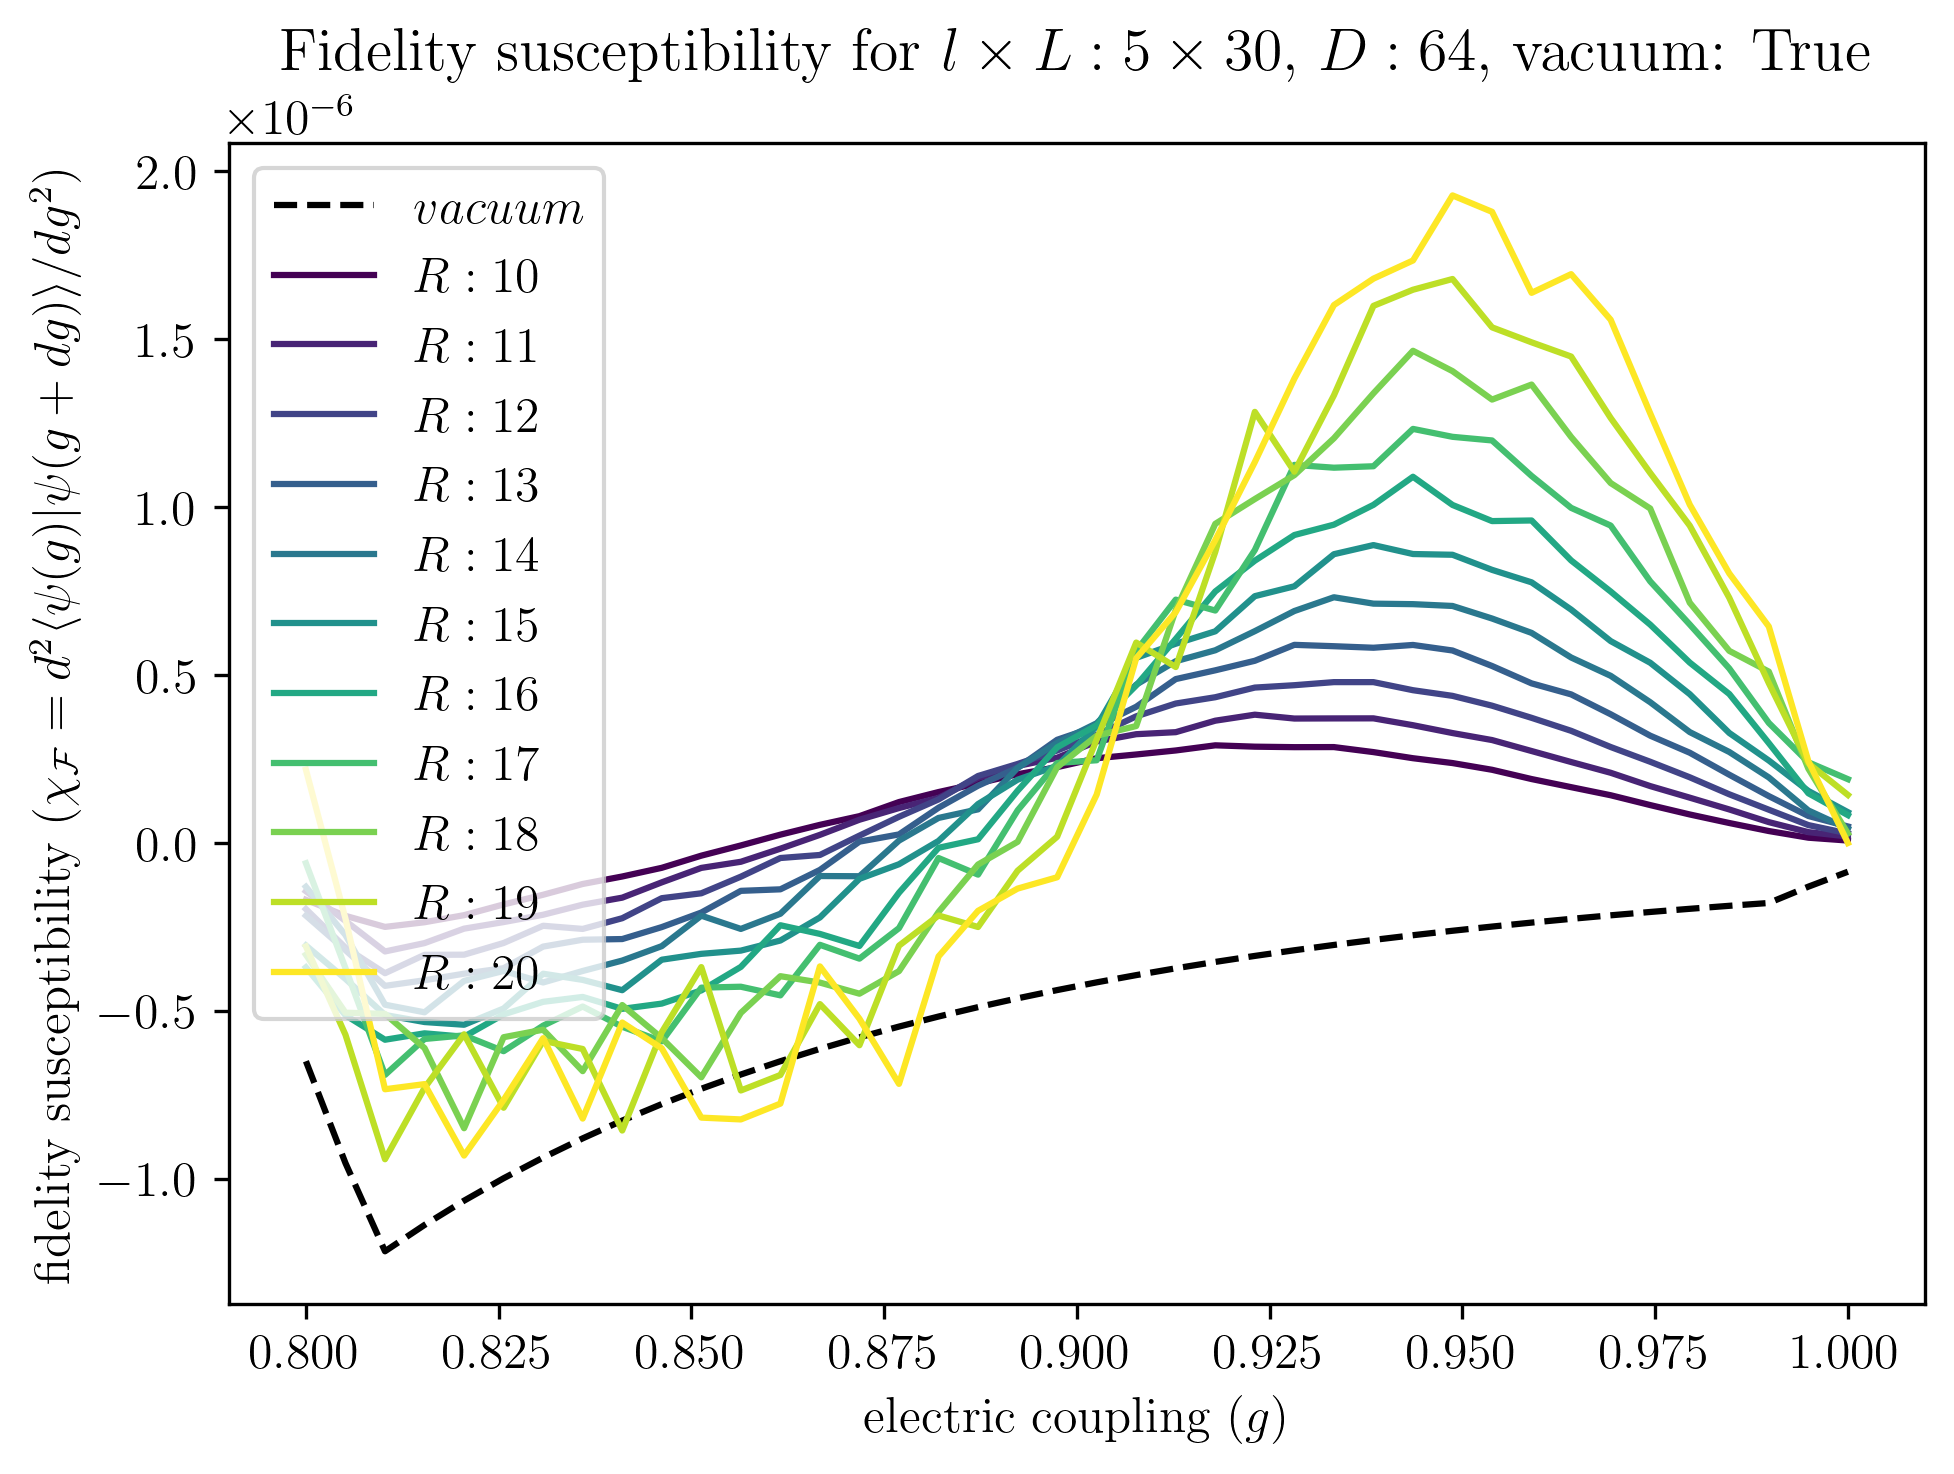

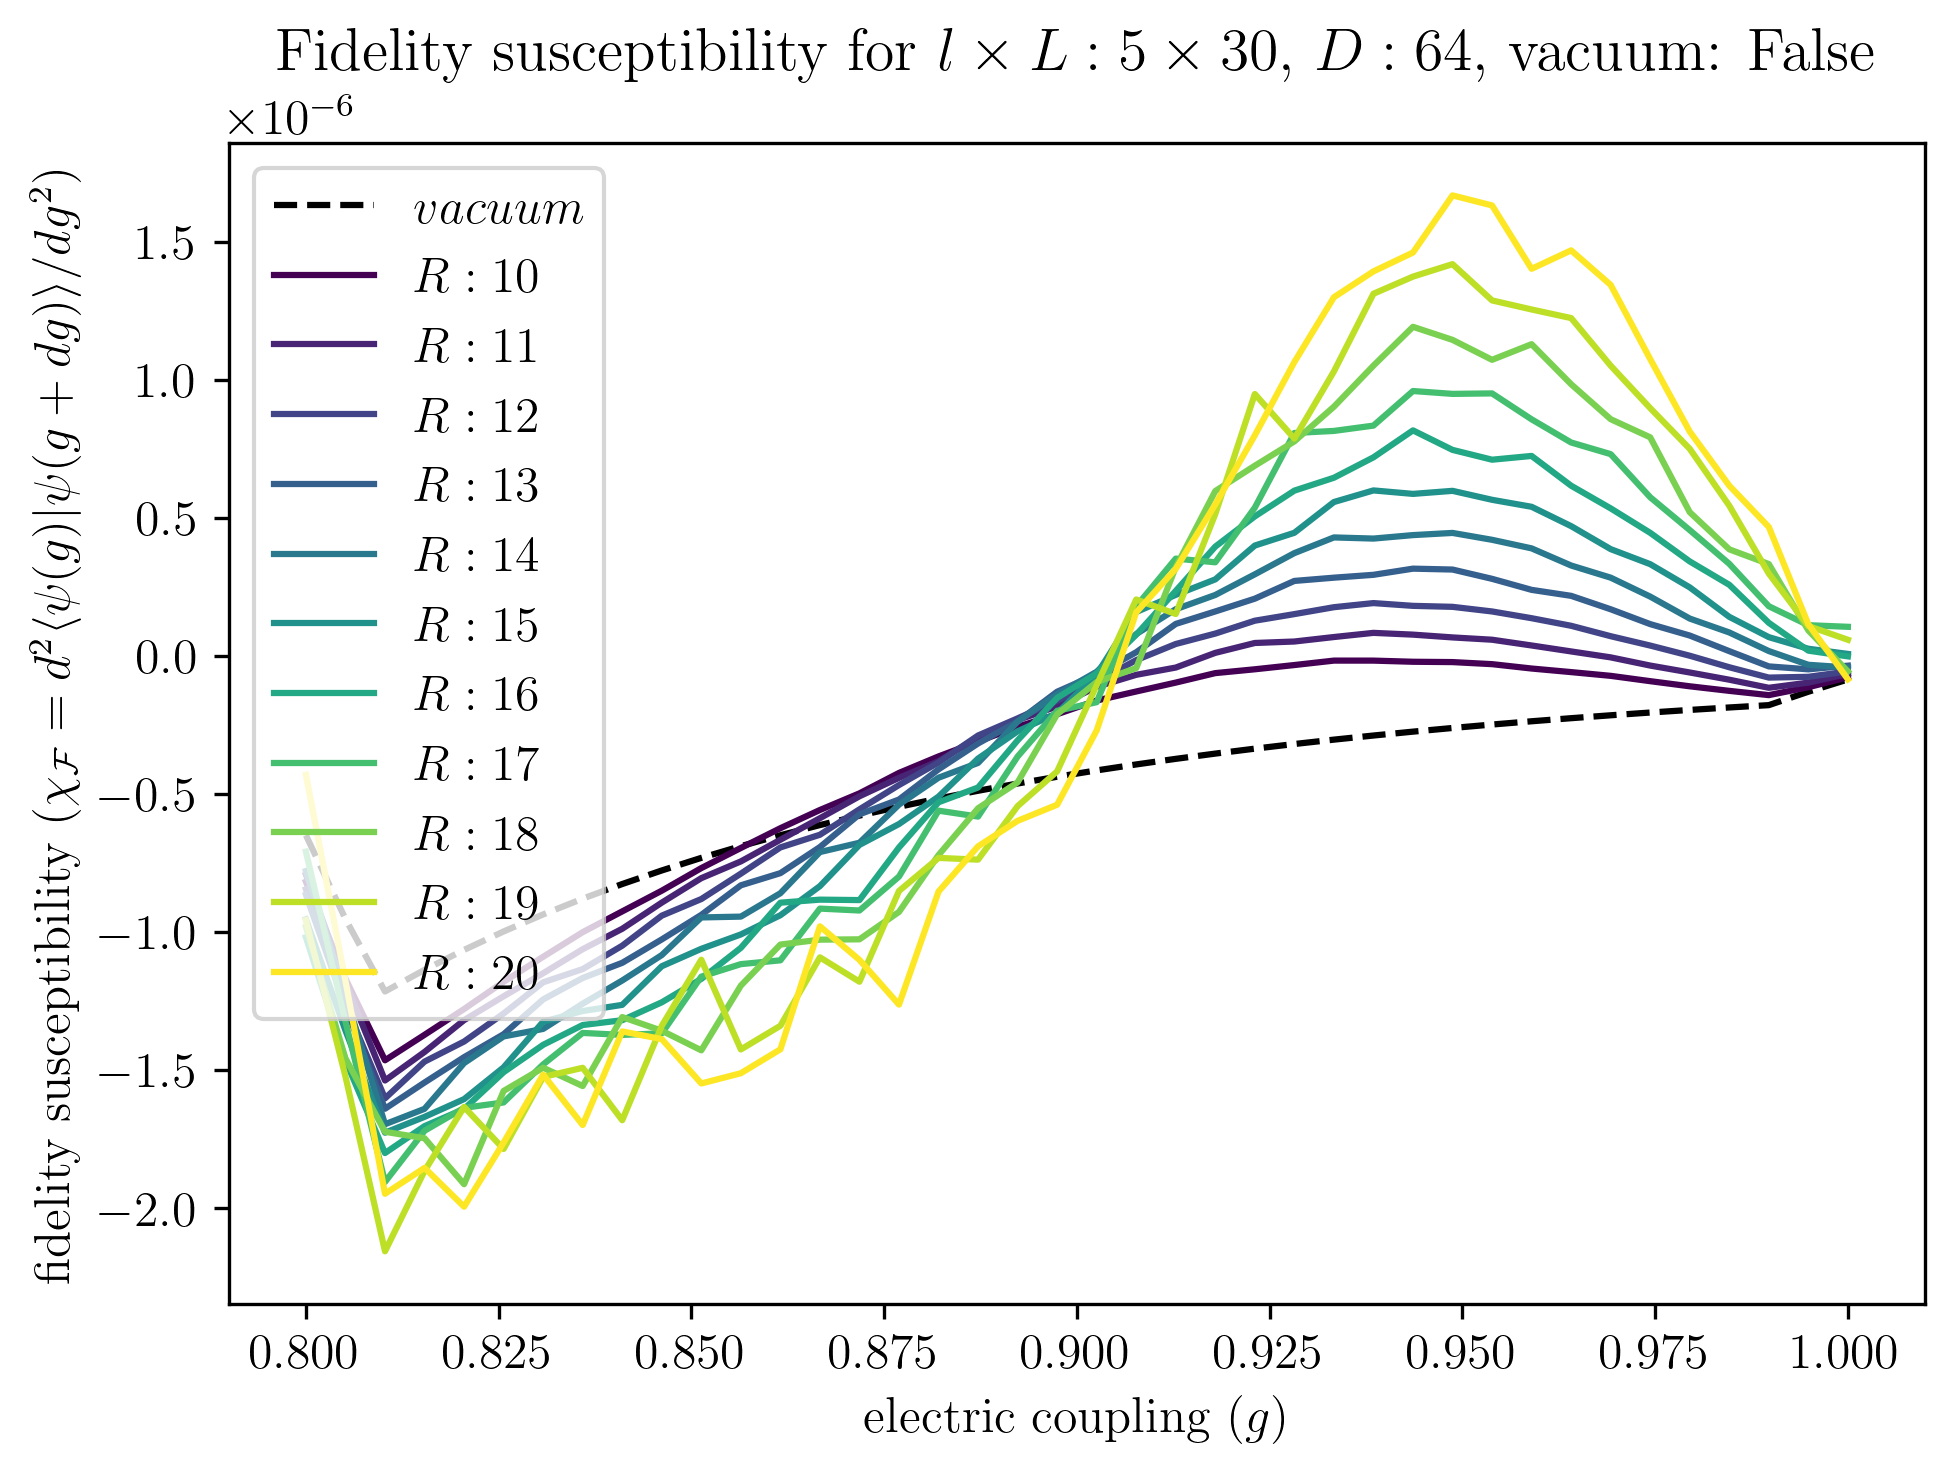

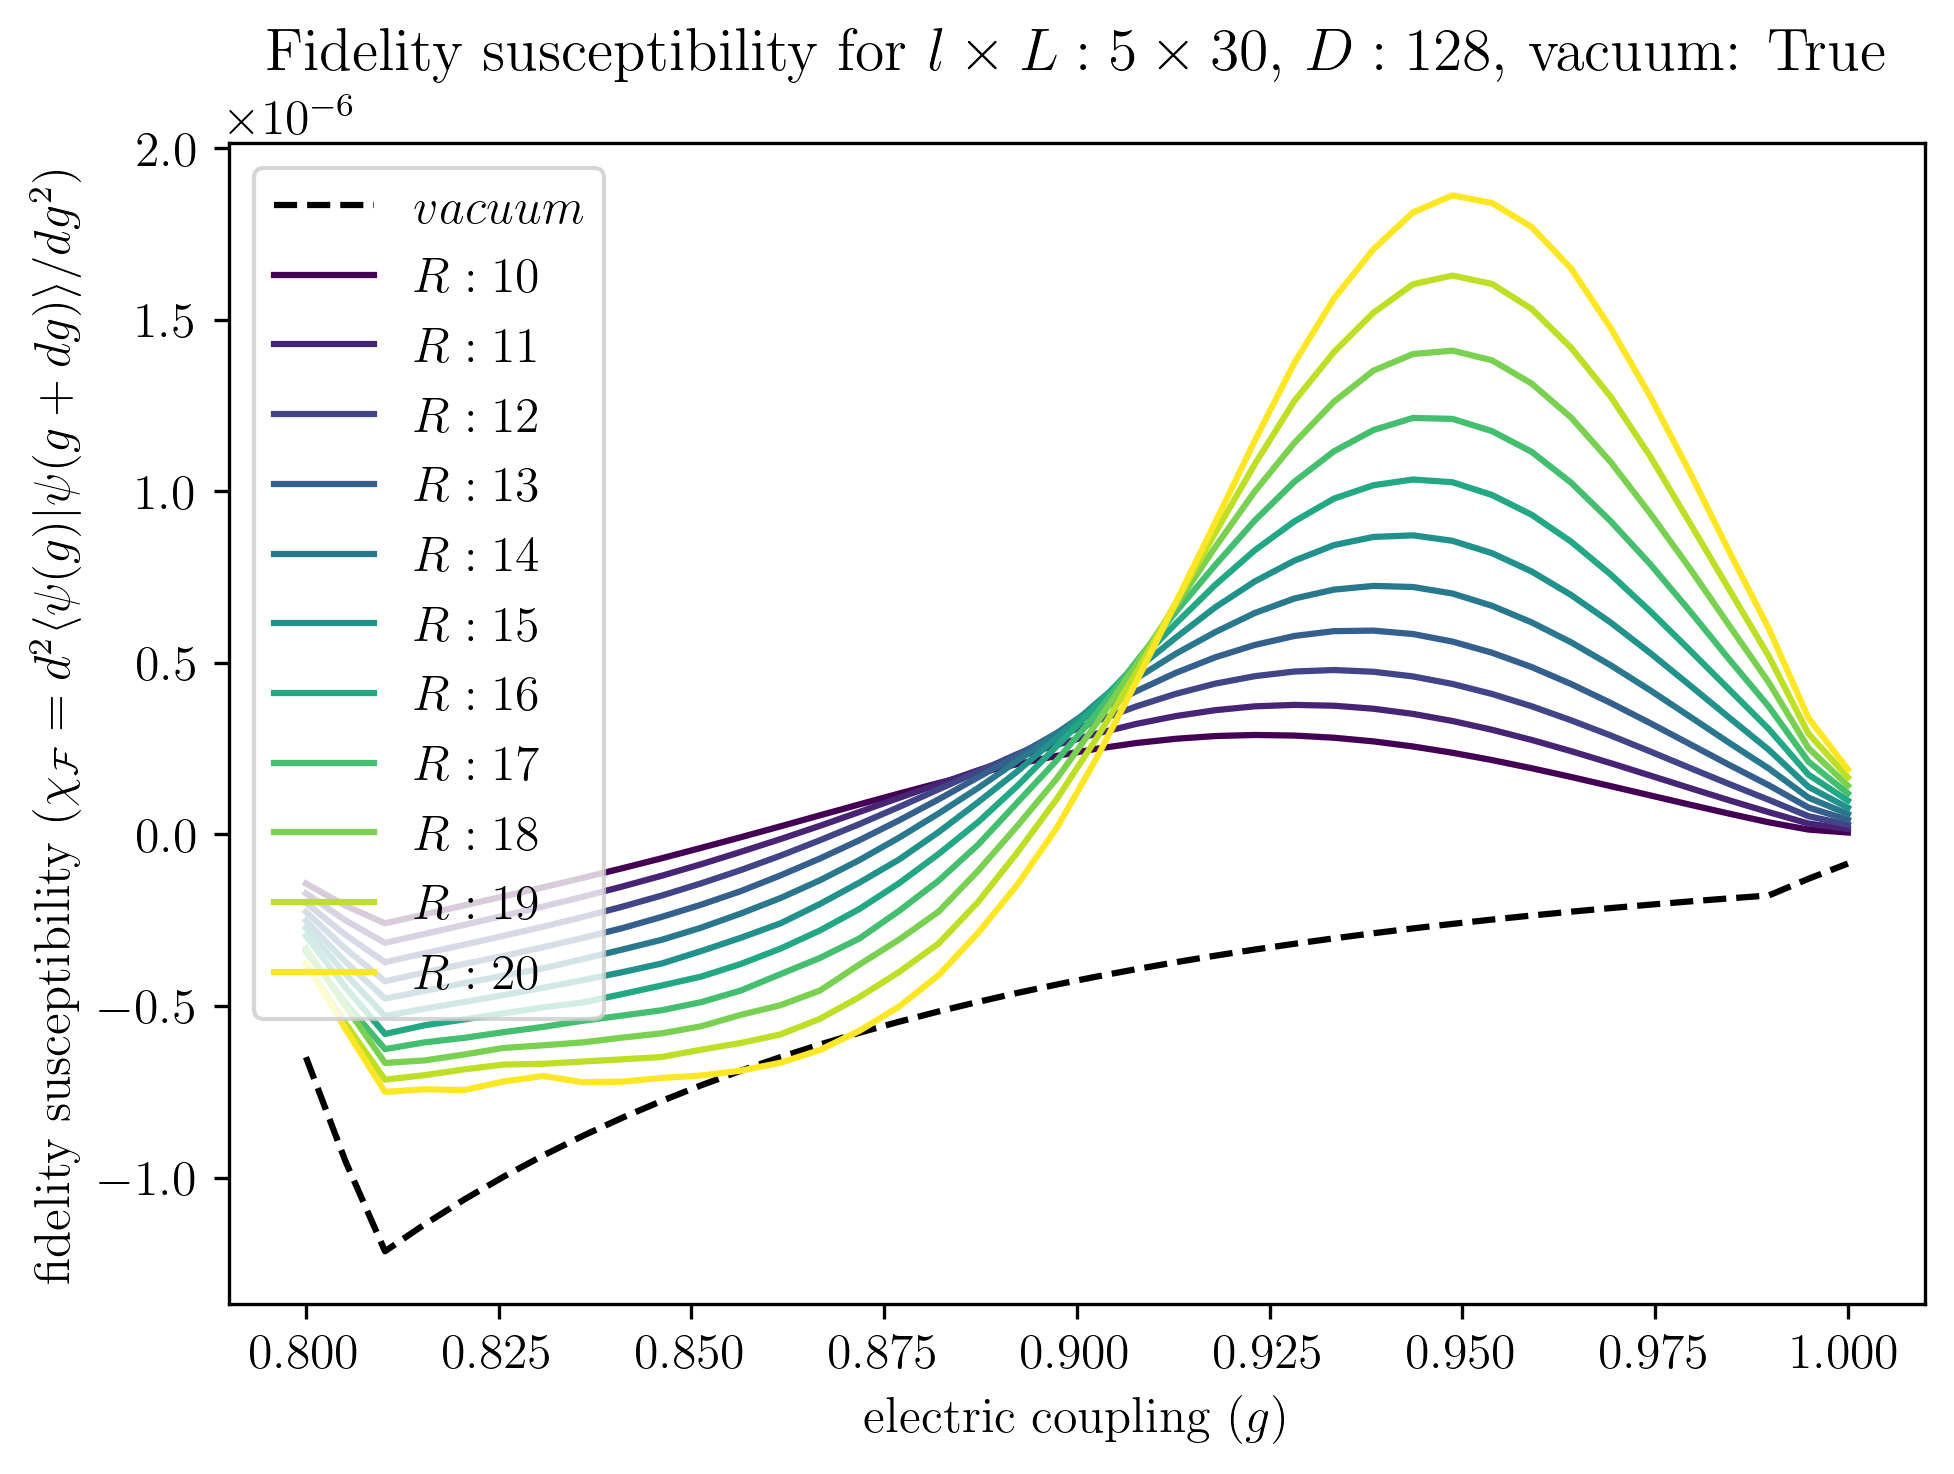

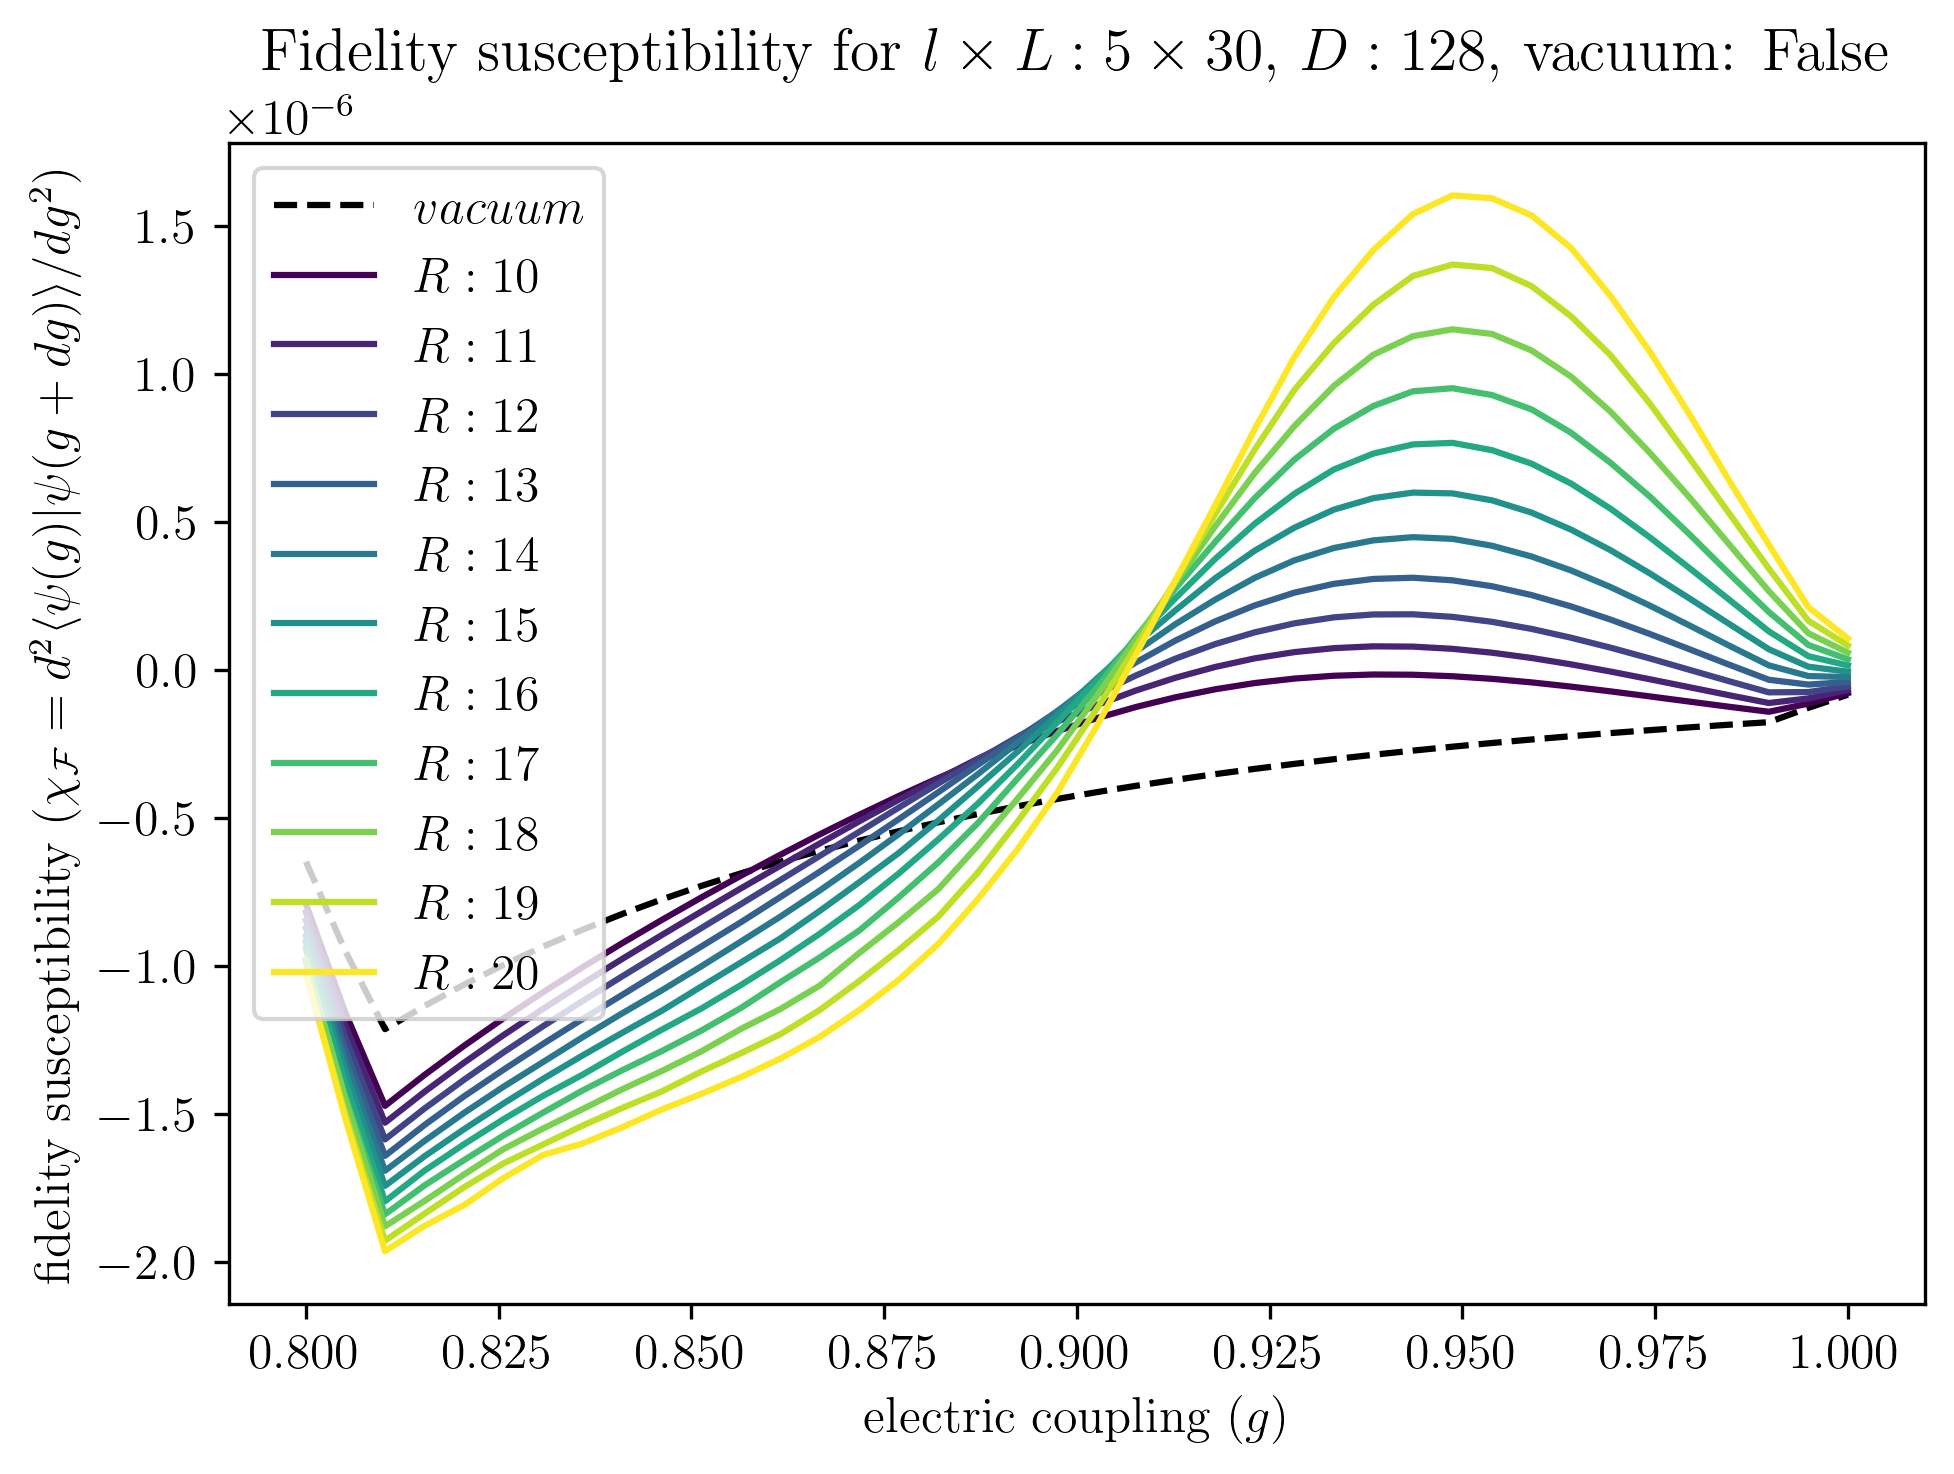

In [30]:
h_i, h_f, npoints = 0.8, 1.0, 41
Rs = [10,11,12,13,14,15,16,17,18,19,20]
# h_i, h_f, npoints = 0.4, 1.0, 61
# Rs = [18,20,22,24]
chis = [64,128]
l = 5
colors = create_sequential_colors(len(Rs))
log = False
rdm = False
vacuum = False

for chi in chis:
    for vacuum in [True, False]:
        gs = np.linspace(h_i, h_f, npoints-1)
        fid_vac = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{0}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy") 
        plt.plot(gs, fid_vac, color='k', linestyle='--', label=f"$vacuum$")
        
        plt.title(f"Fidelity susceptibility for $l \\times L: {l} \\times {L}$, $D:{chi}$, vacuum: {vacuum}")
        # plt.title(f"$\\chi_{{\\mathcal{{F}}}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2$ for $l \\times L: {l} \\times {L}$, $D:{chi}$, $log: {log}$")
        plt.xlabel("electric coupling $(g)$")
        plt.ylabel("fidelity susceptibility $(\\chi_{\\mathcal{F}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2)$")
        
        for i, R in enumerate(Rs):
            fidelities = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{R}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
            if vacuum:
                fidelities = fidelities - fid_vac
            plt.plot(gs, fidelities, color=colors[i], label=f"$R: {R}$")
        plt.legend()
        plt.savefig(f"{path_figures}/fluxtube/fidelity_susceptibility_log_scale_False_rdm_{rdm}_vacuum_{vacuum}_{model}_{l}x{L}_bc_{bc}_Rs_{Rs}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")
        plt.show()
        plt.close()

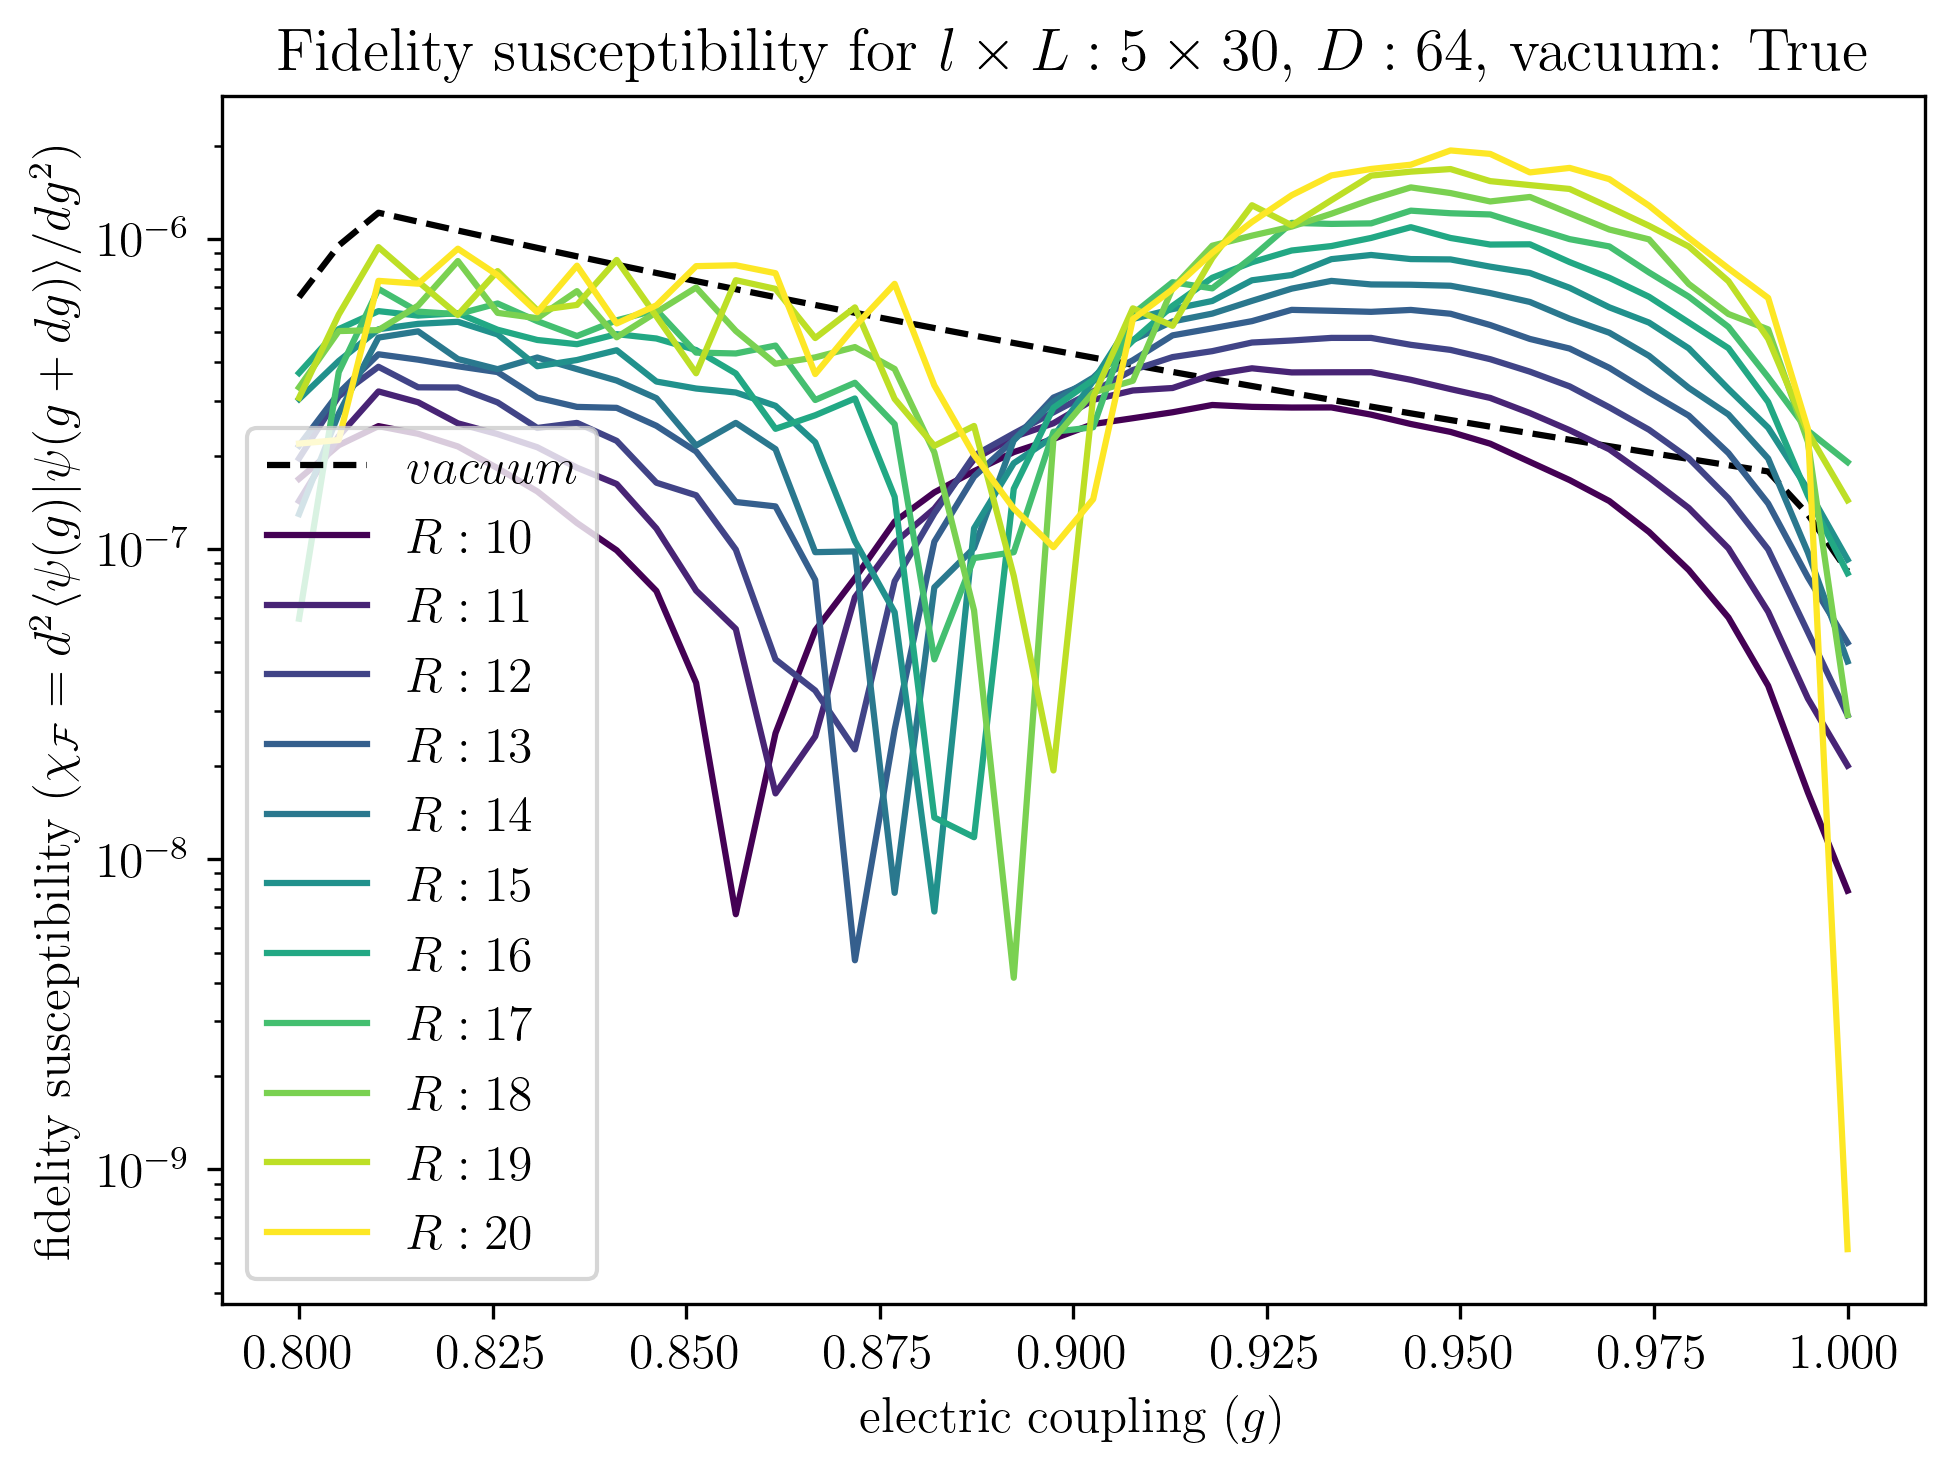

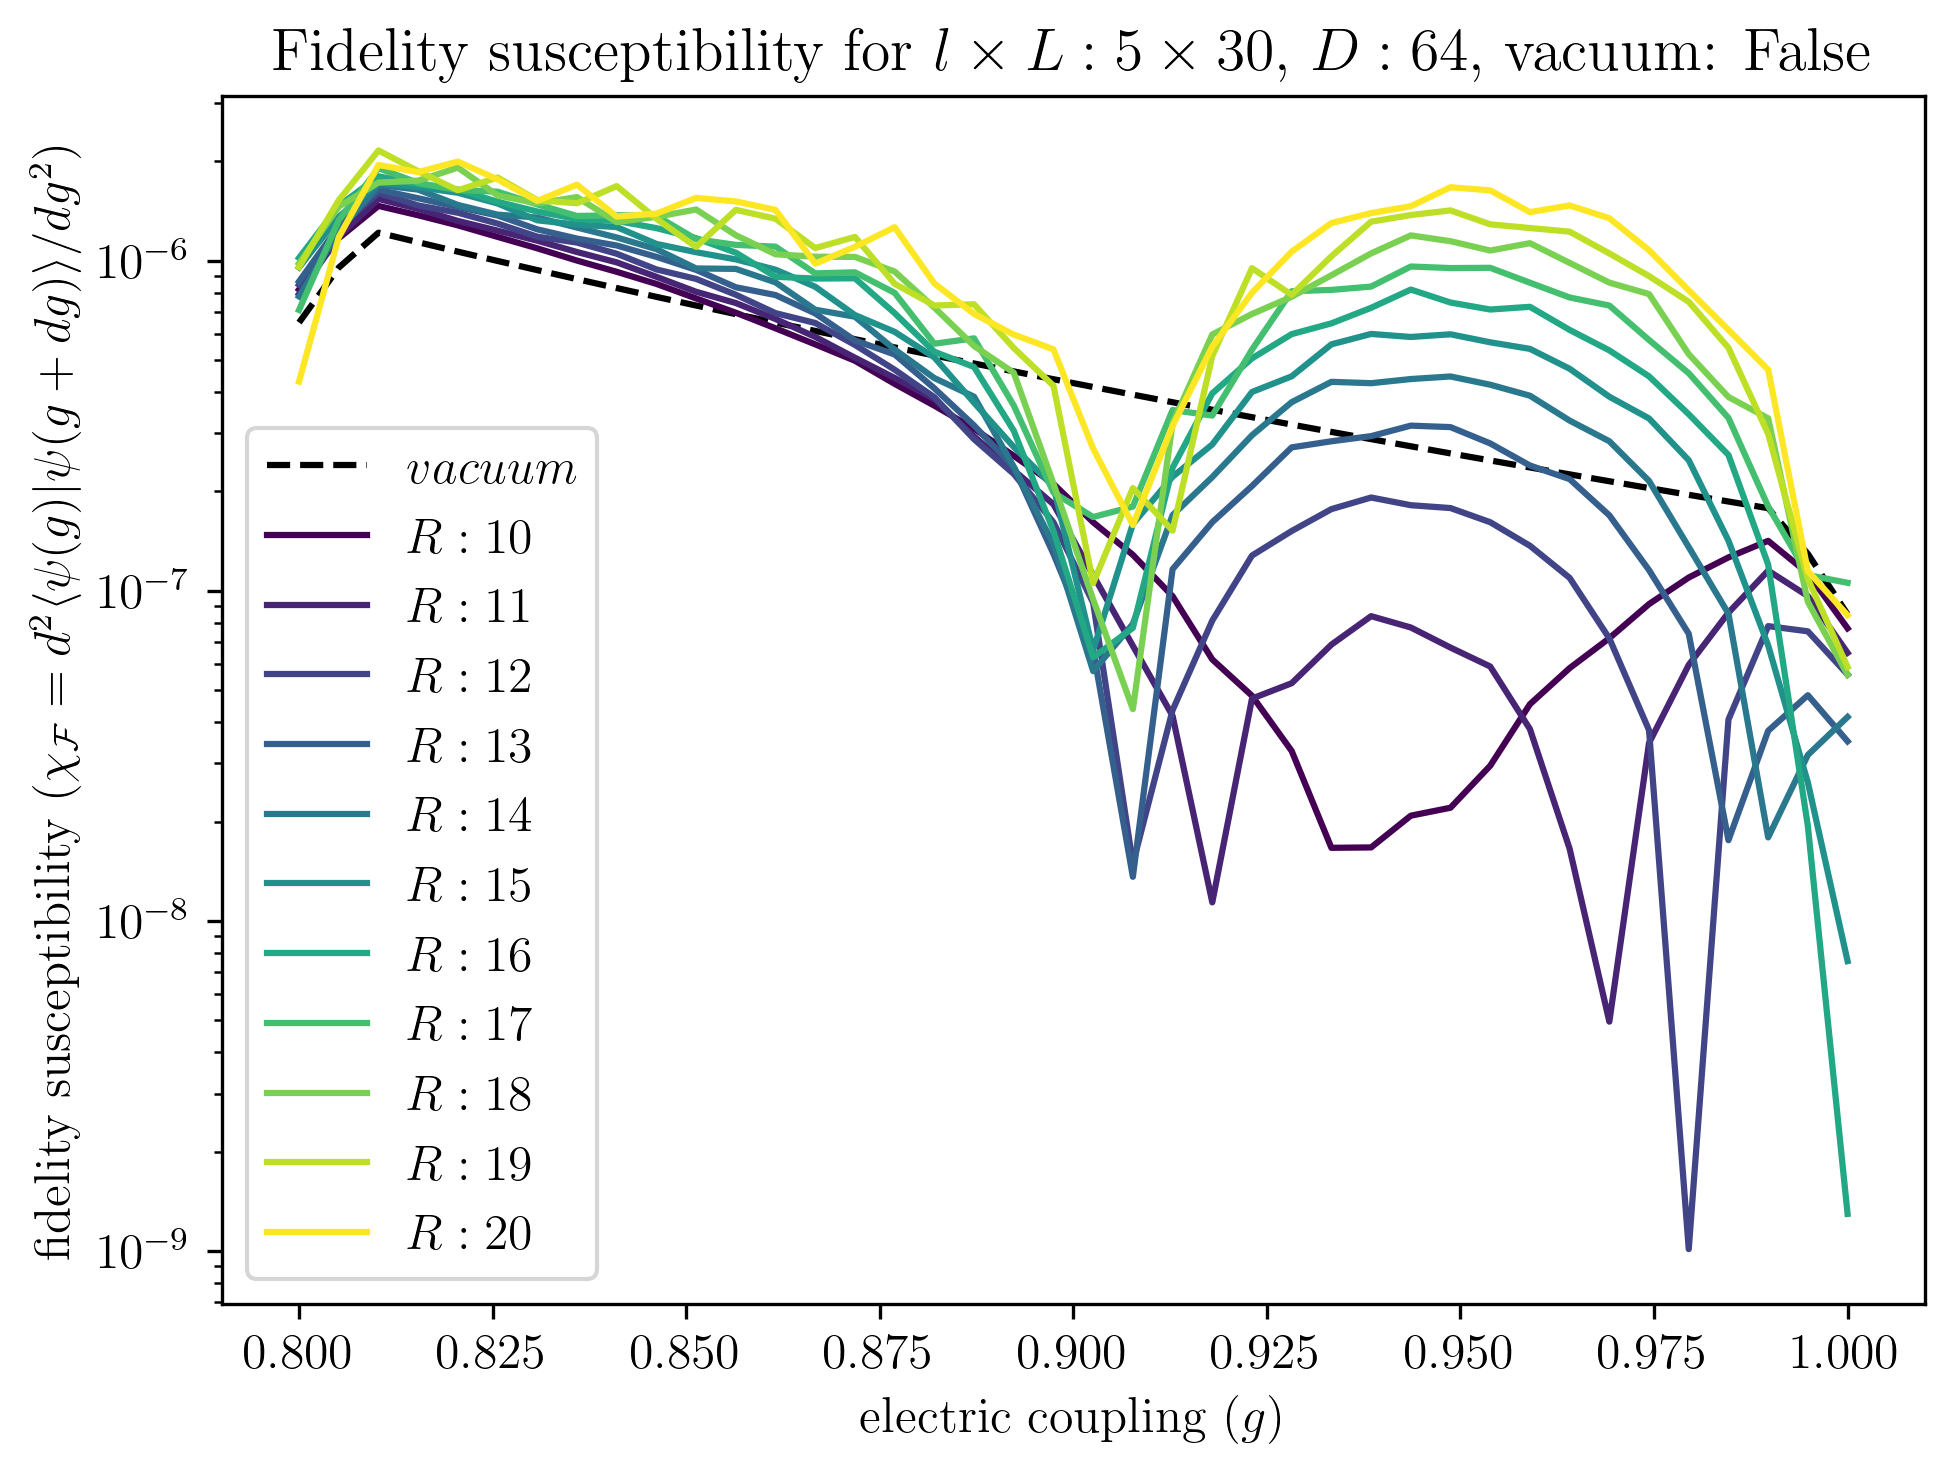

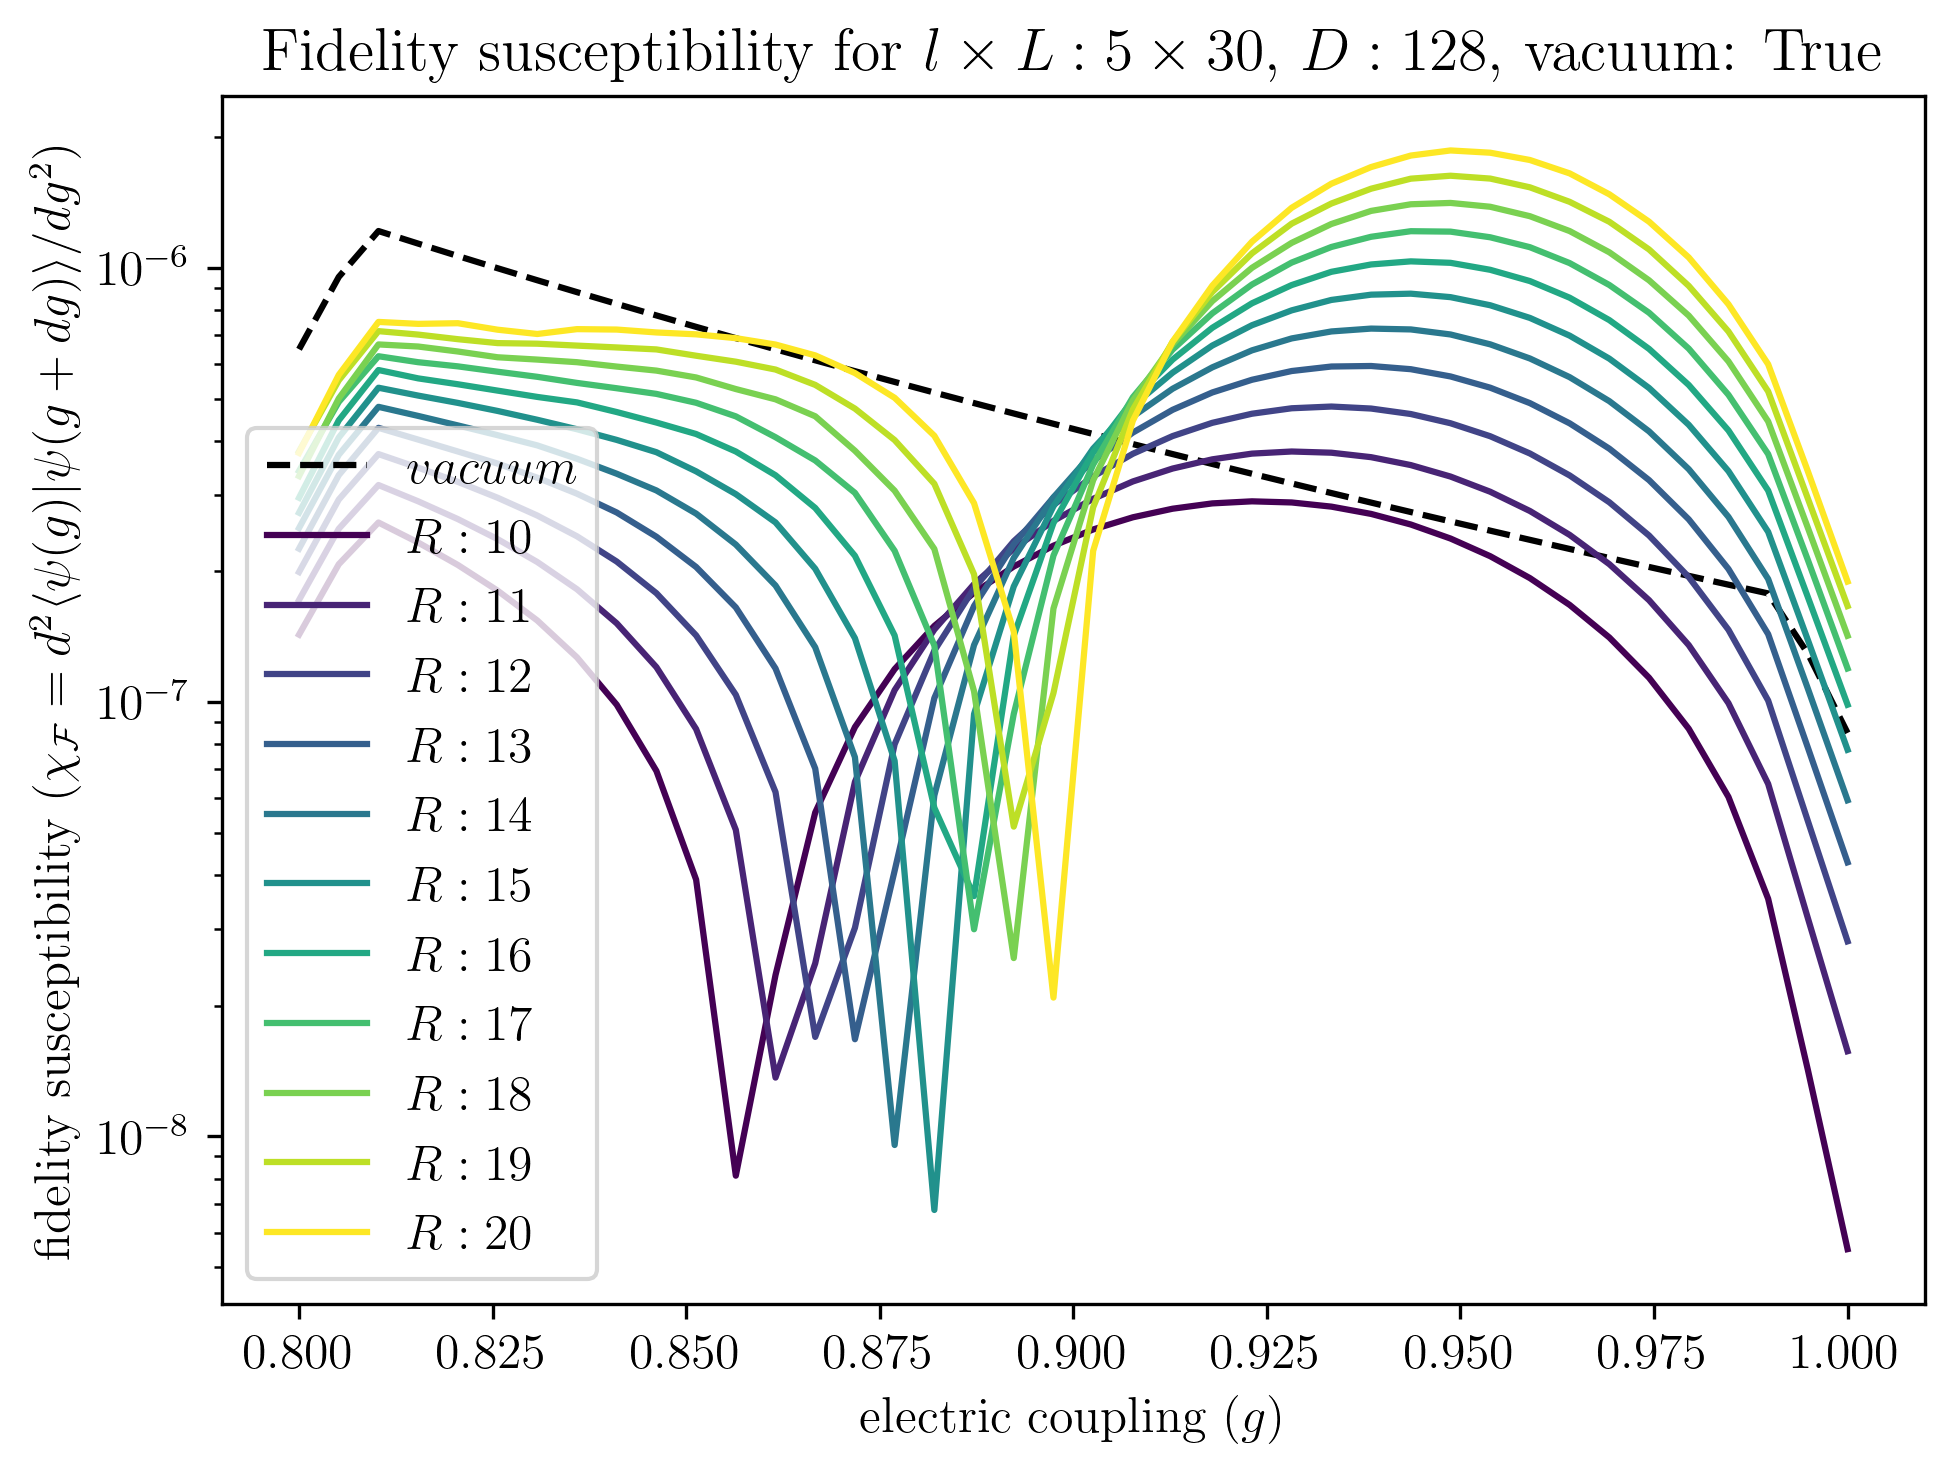

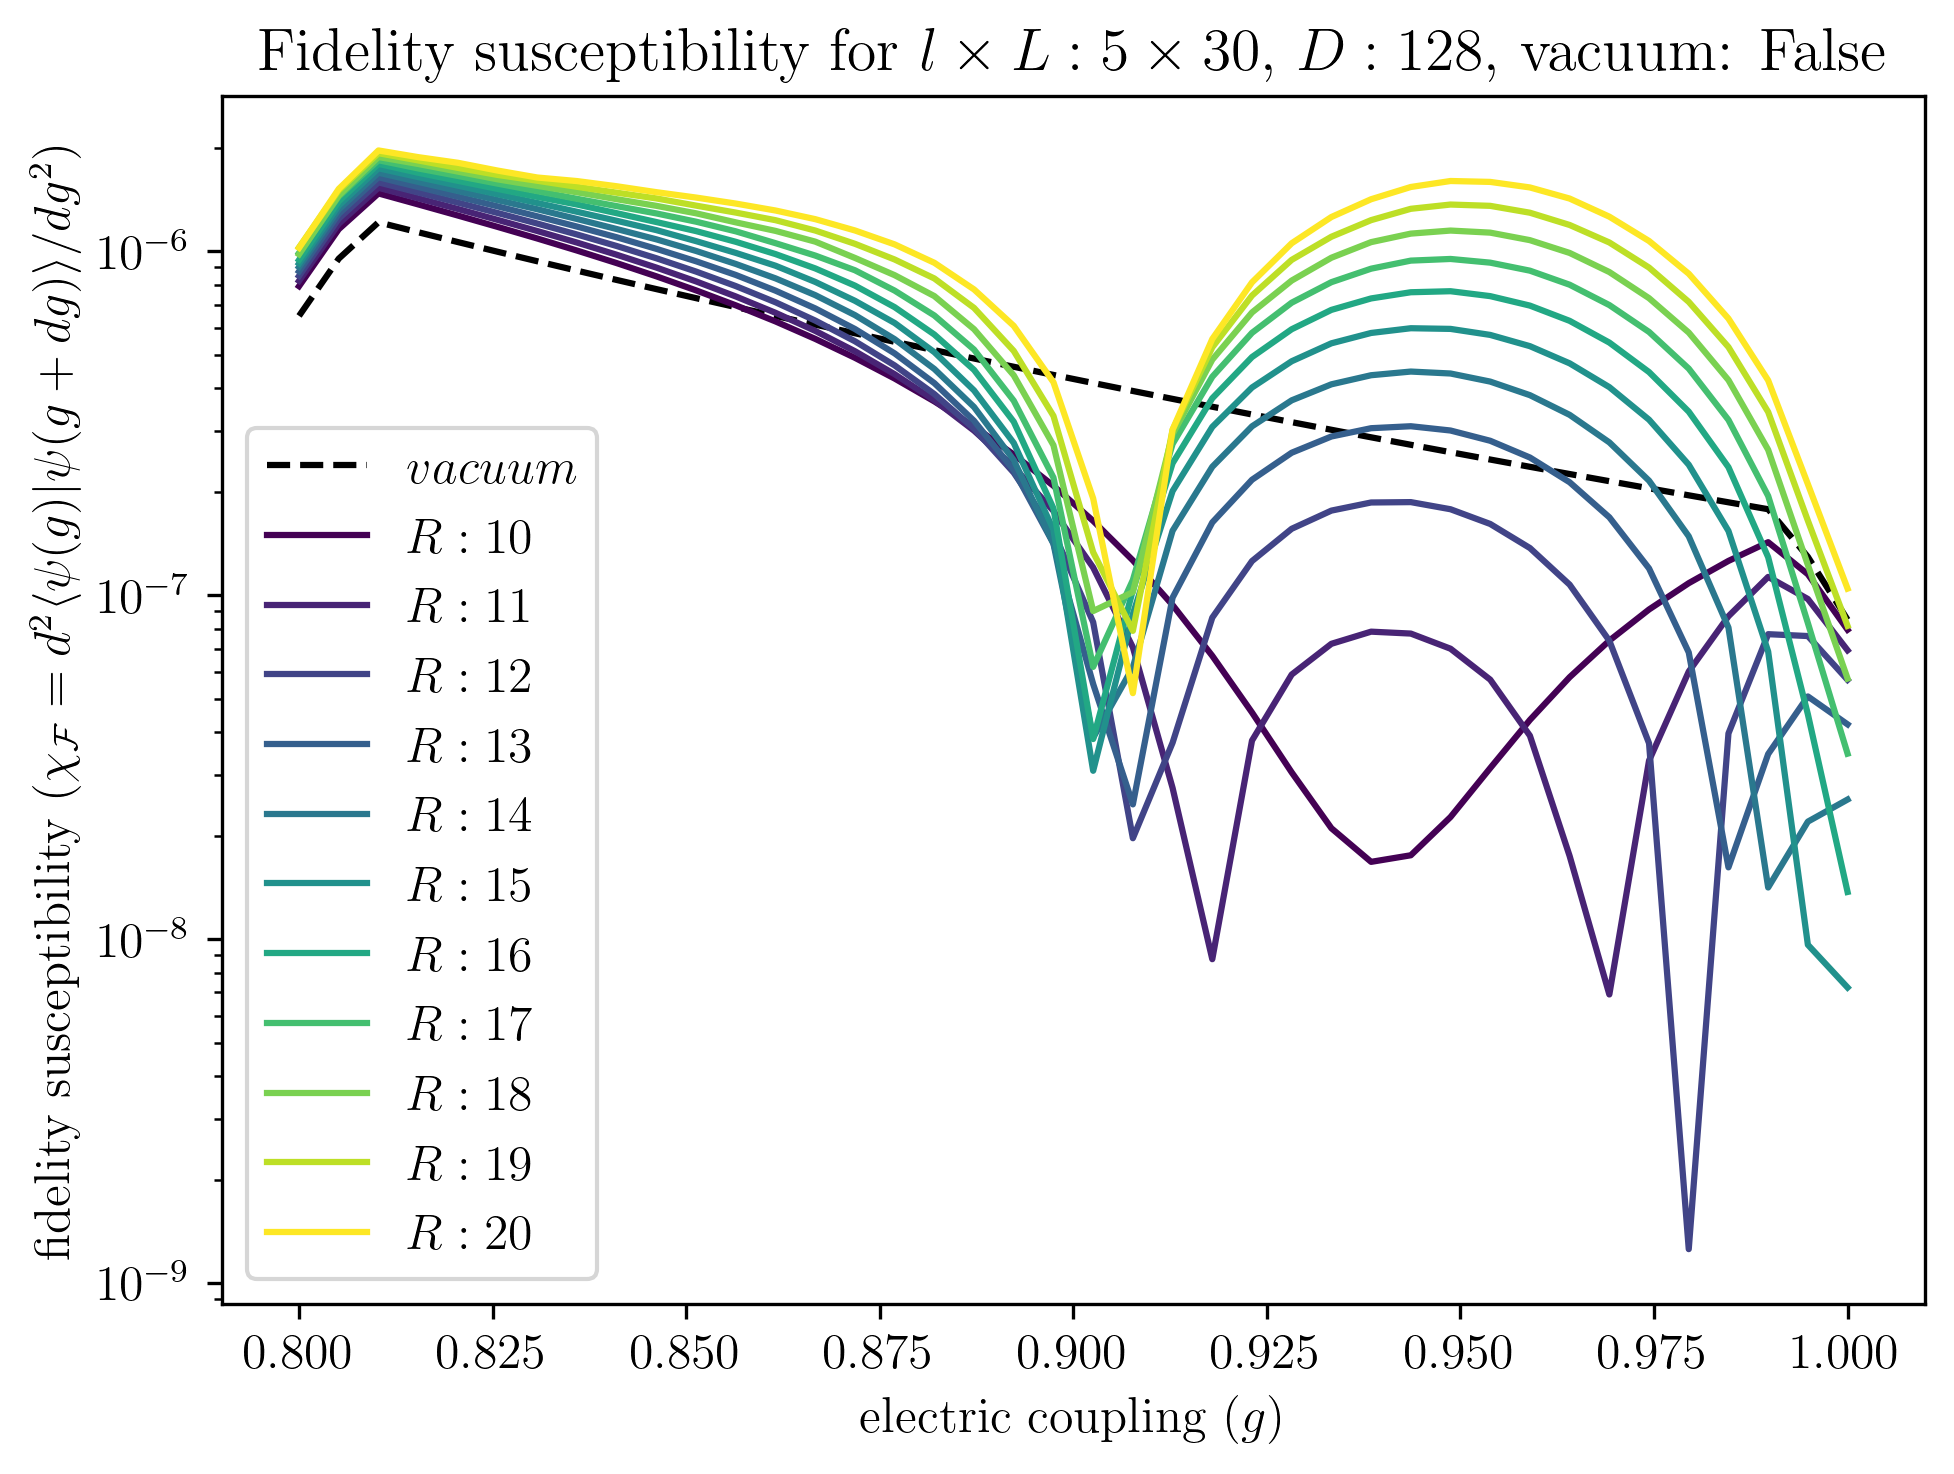

In [31]:
for chi in chis:
    for vacuum in [True, False]:
        gs = np.linspace(h_i, h_f, npoints-1)
        fid_vac = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{0}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy") 
        plt.plot(gs, np.abs(fid_vac), color='k', linestyle='--', label=f"$vacuum$")

        plt.title(f"Fidelity susceptibility for $l \\times L: {l} \\times {L}$, $D:{chi}$, vacuum: {vacuum}")
        # plt.title(f"$\\chi_{{\\mathcal{{F}}}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2$ for $l \\times L: {l} \\times {L}$, $D:{chi}$, $log: {log}$")
        plt.xlabel("electric coupling $(g)$")
        plt.ylabel("fidelity susceptibility $(\\chi_{\\mathcal{F}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2)$")
        for i, R in enumerate(Rs):
            fidelities = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{R}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
            if vacuum:
                fidelities = fidelities - fid_vac
            plt.plot(gs, np.abs(fidelities), color=colors[i], label=f"$R: {R}$")
        plt.yscale('log')
        plt.legend()
        plt.savefig(f"{path_figures}/fluxtube/fidelity_susceptibility_log_scale_True_rdm_{rdm}_vacuum_{vacuum}_{model}_{l}x{L}_bc_{bc}_Rs_{Rs}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")
        plt.show()
        plt.close()

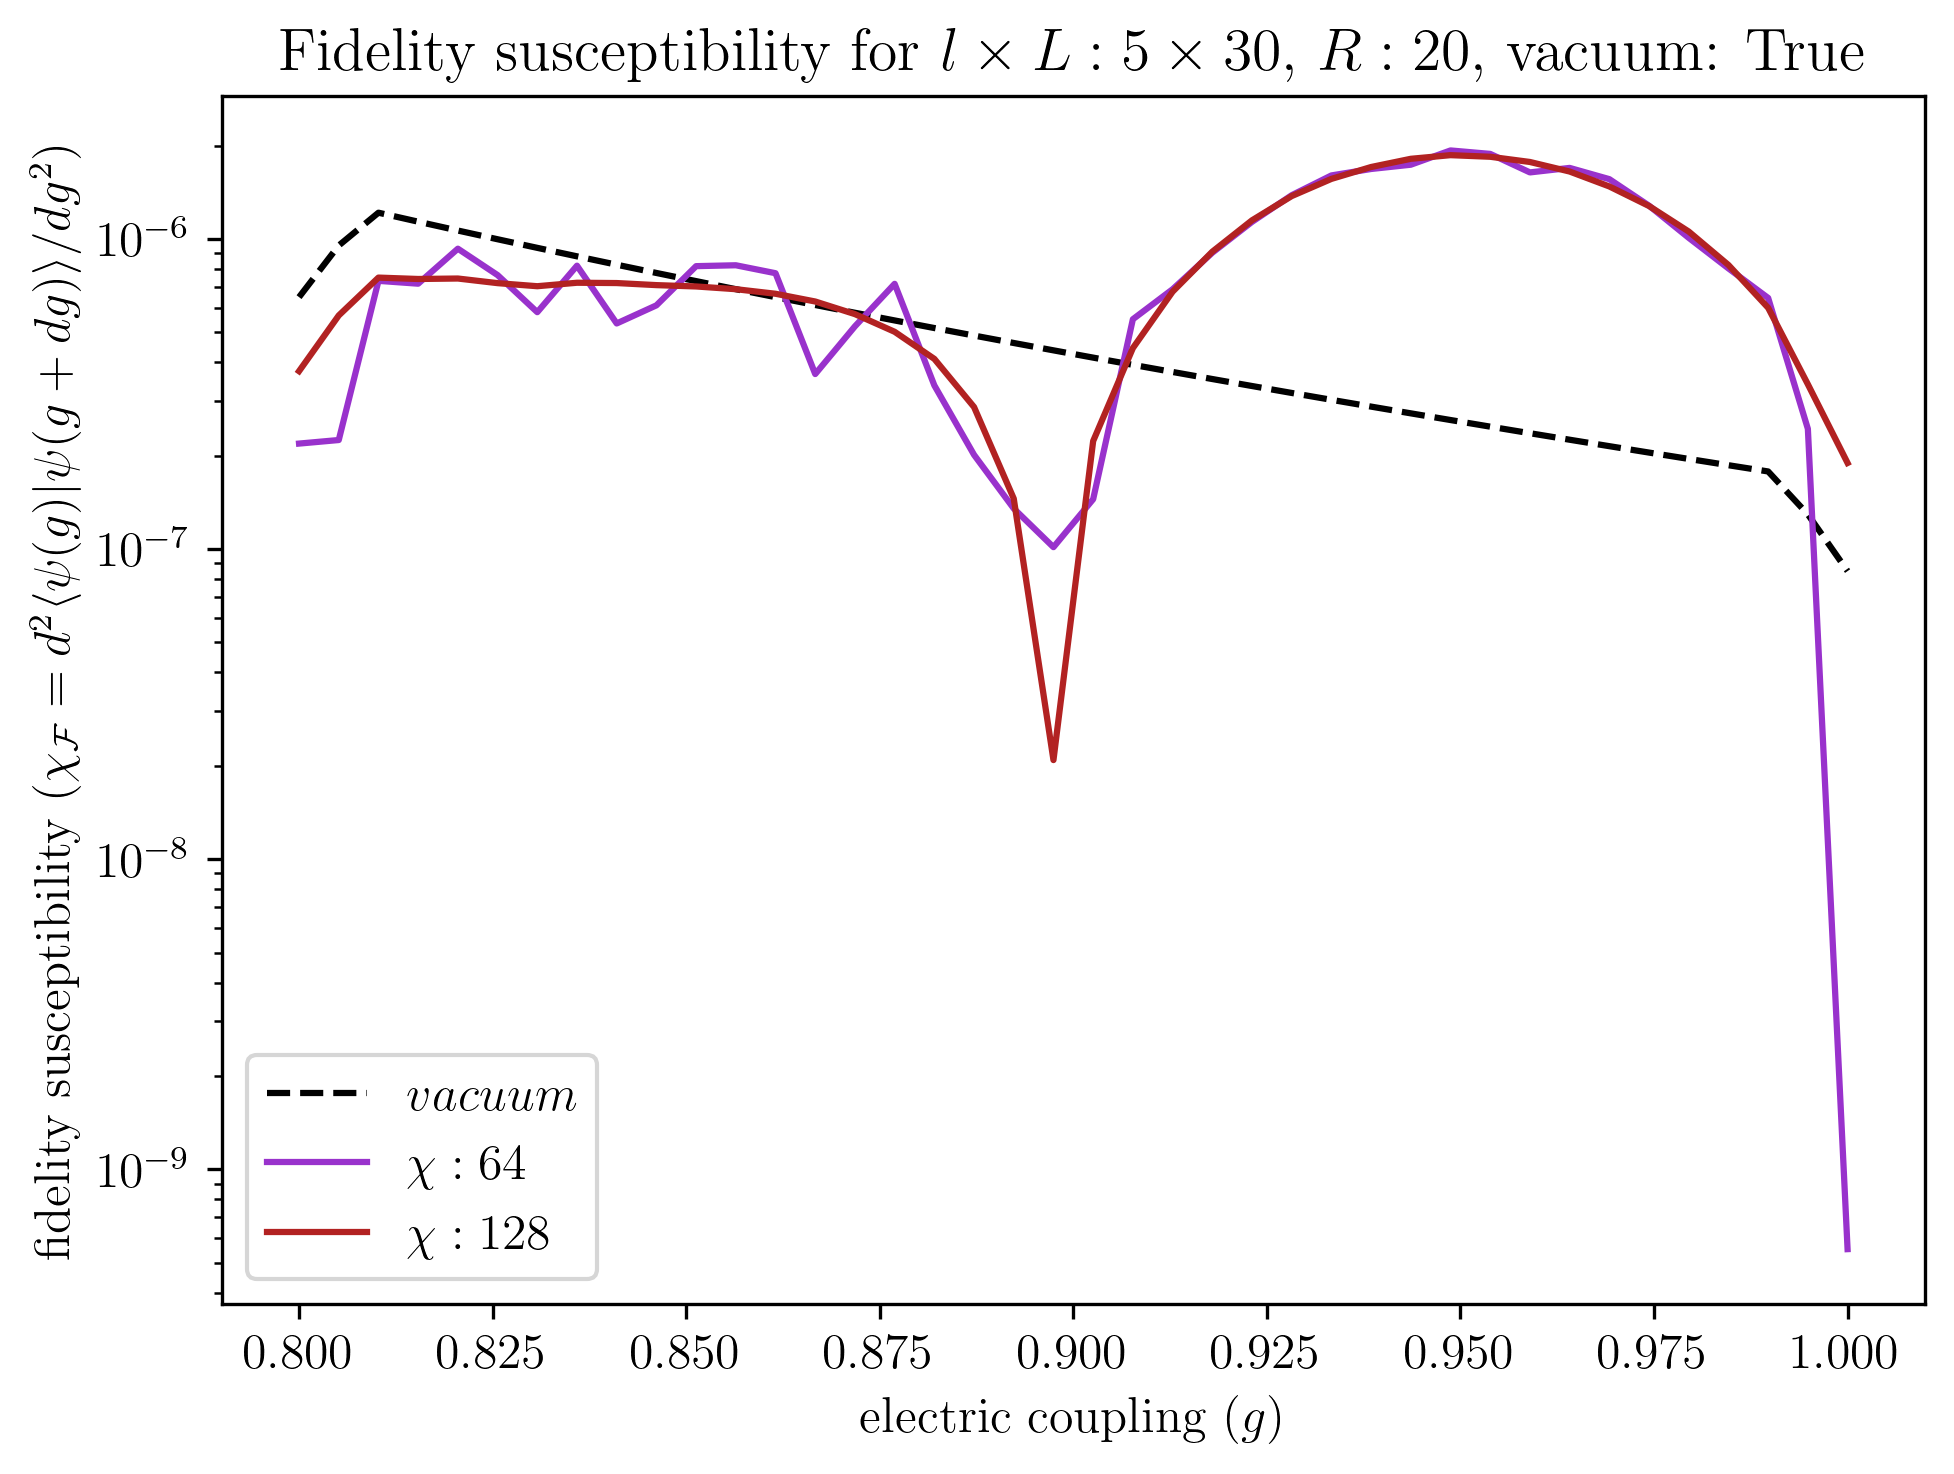

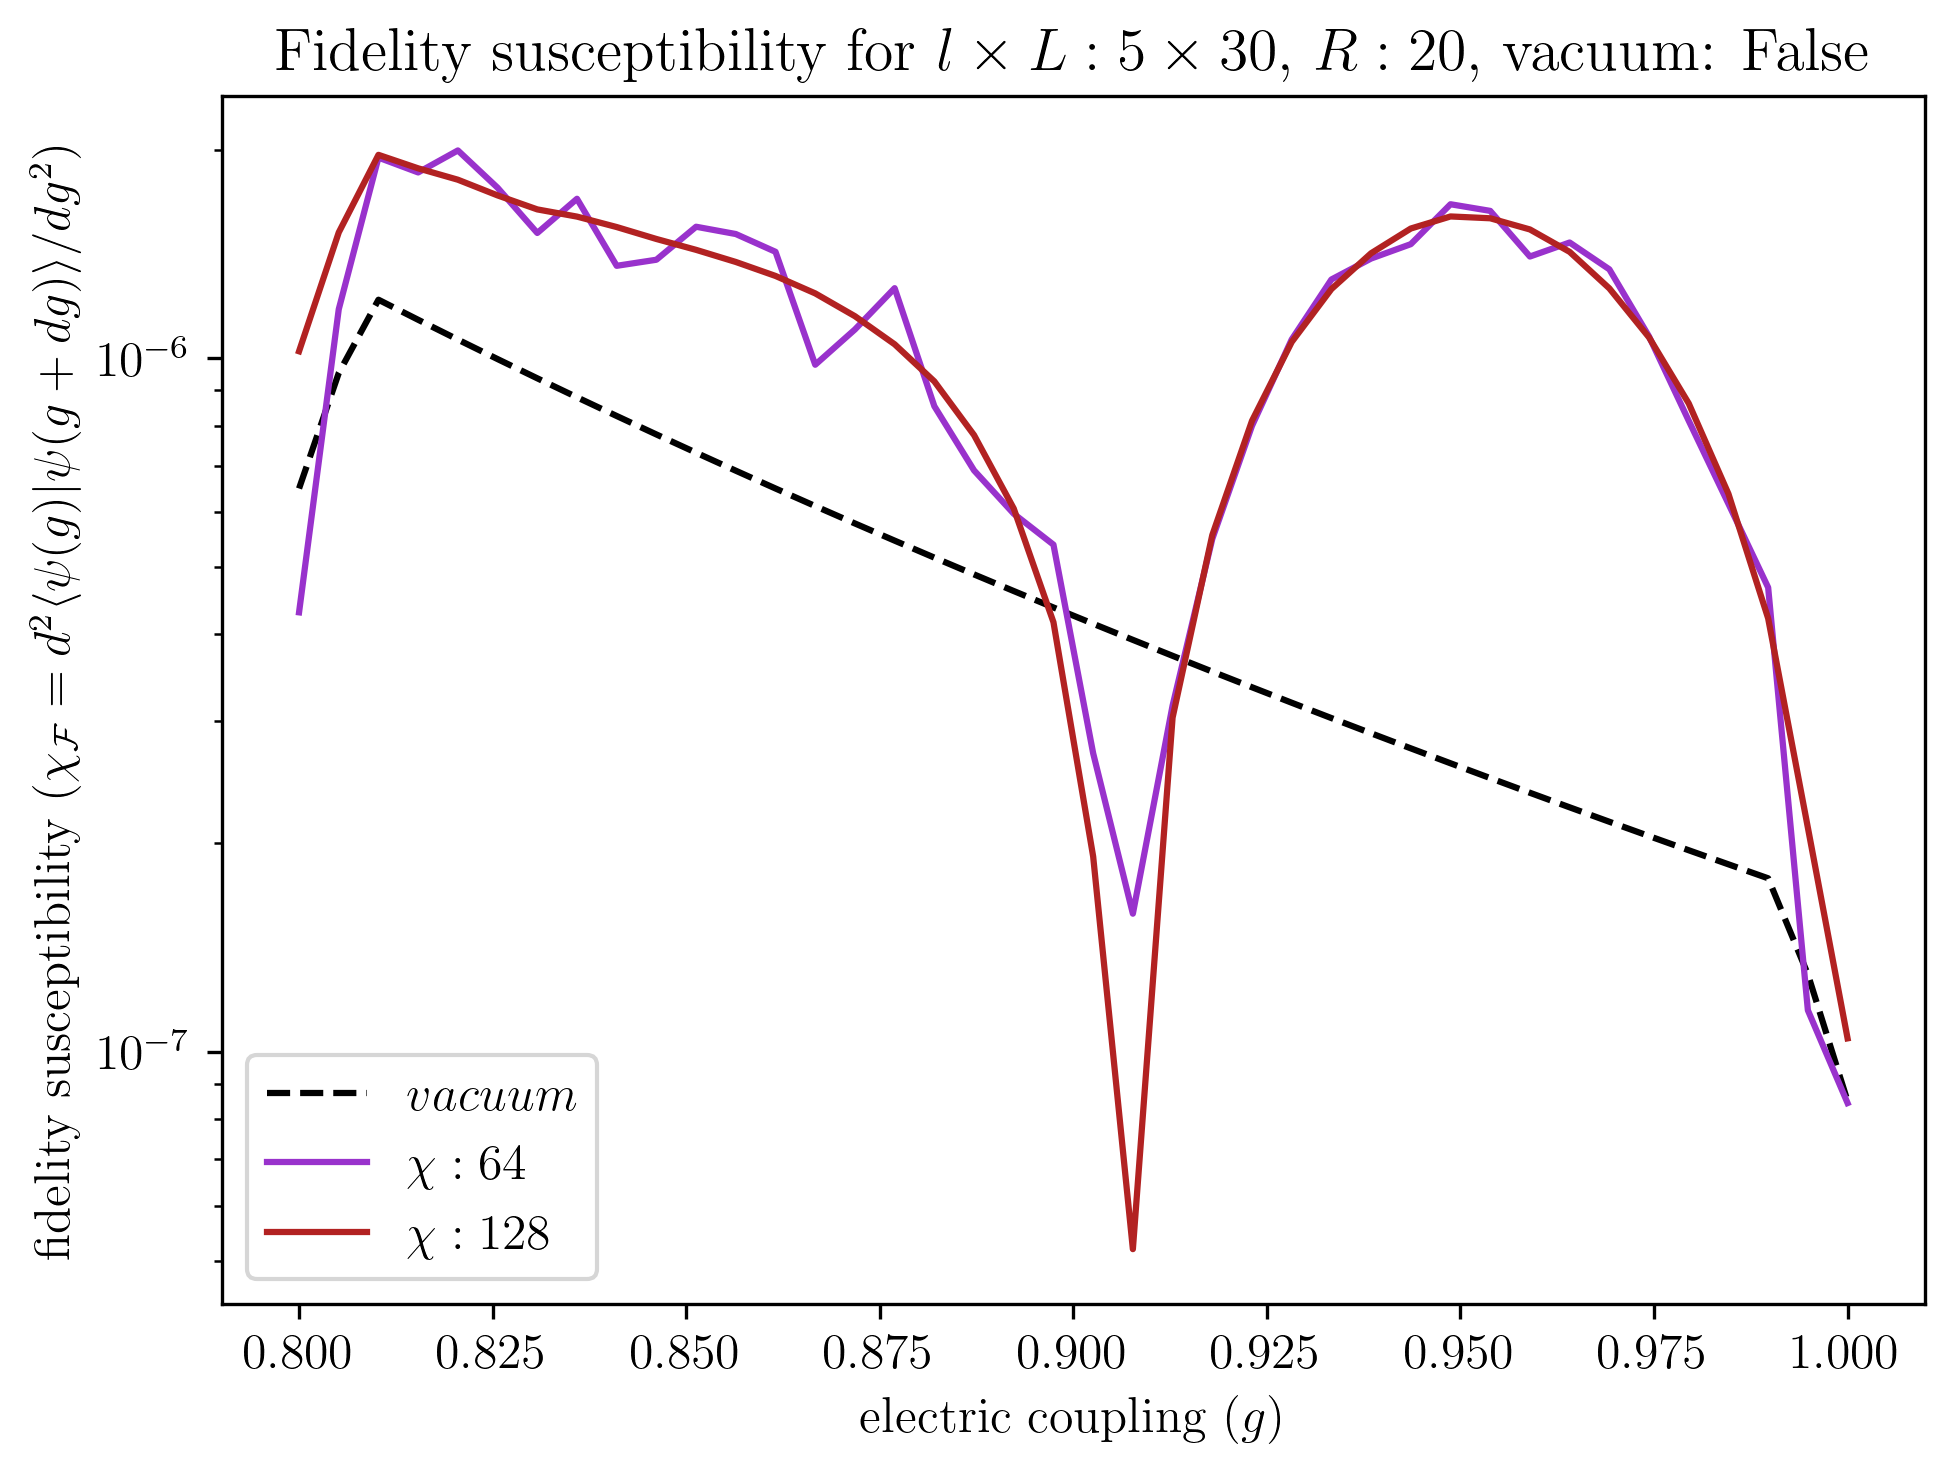

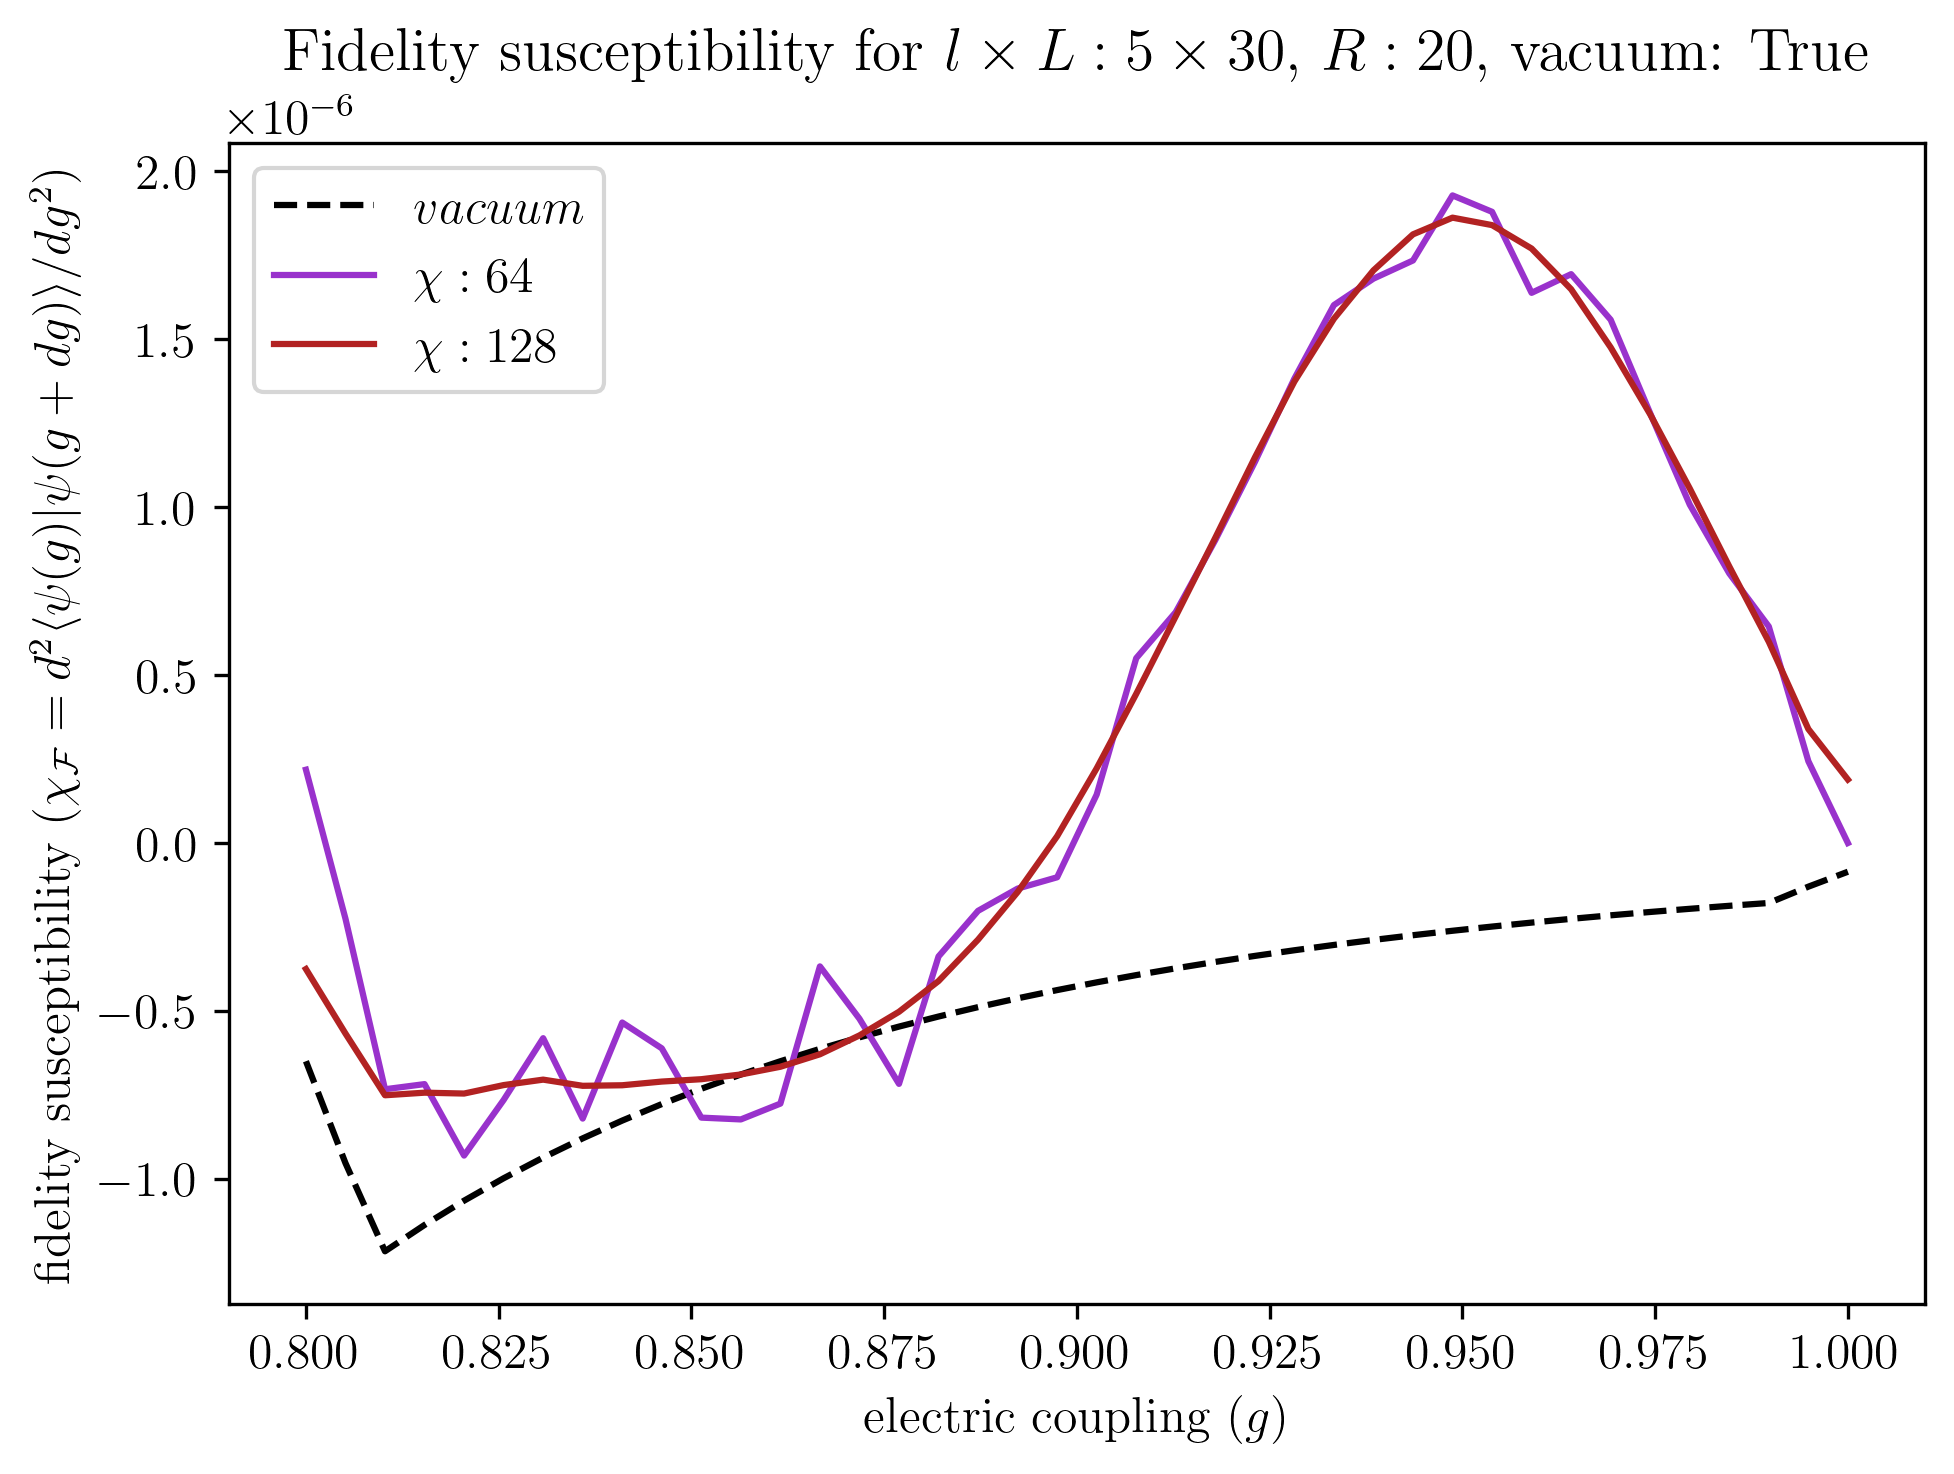

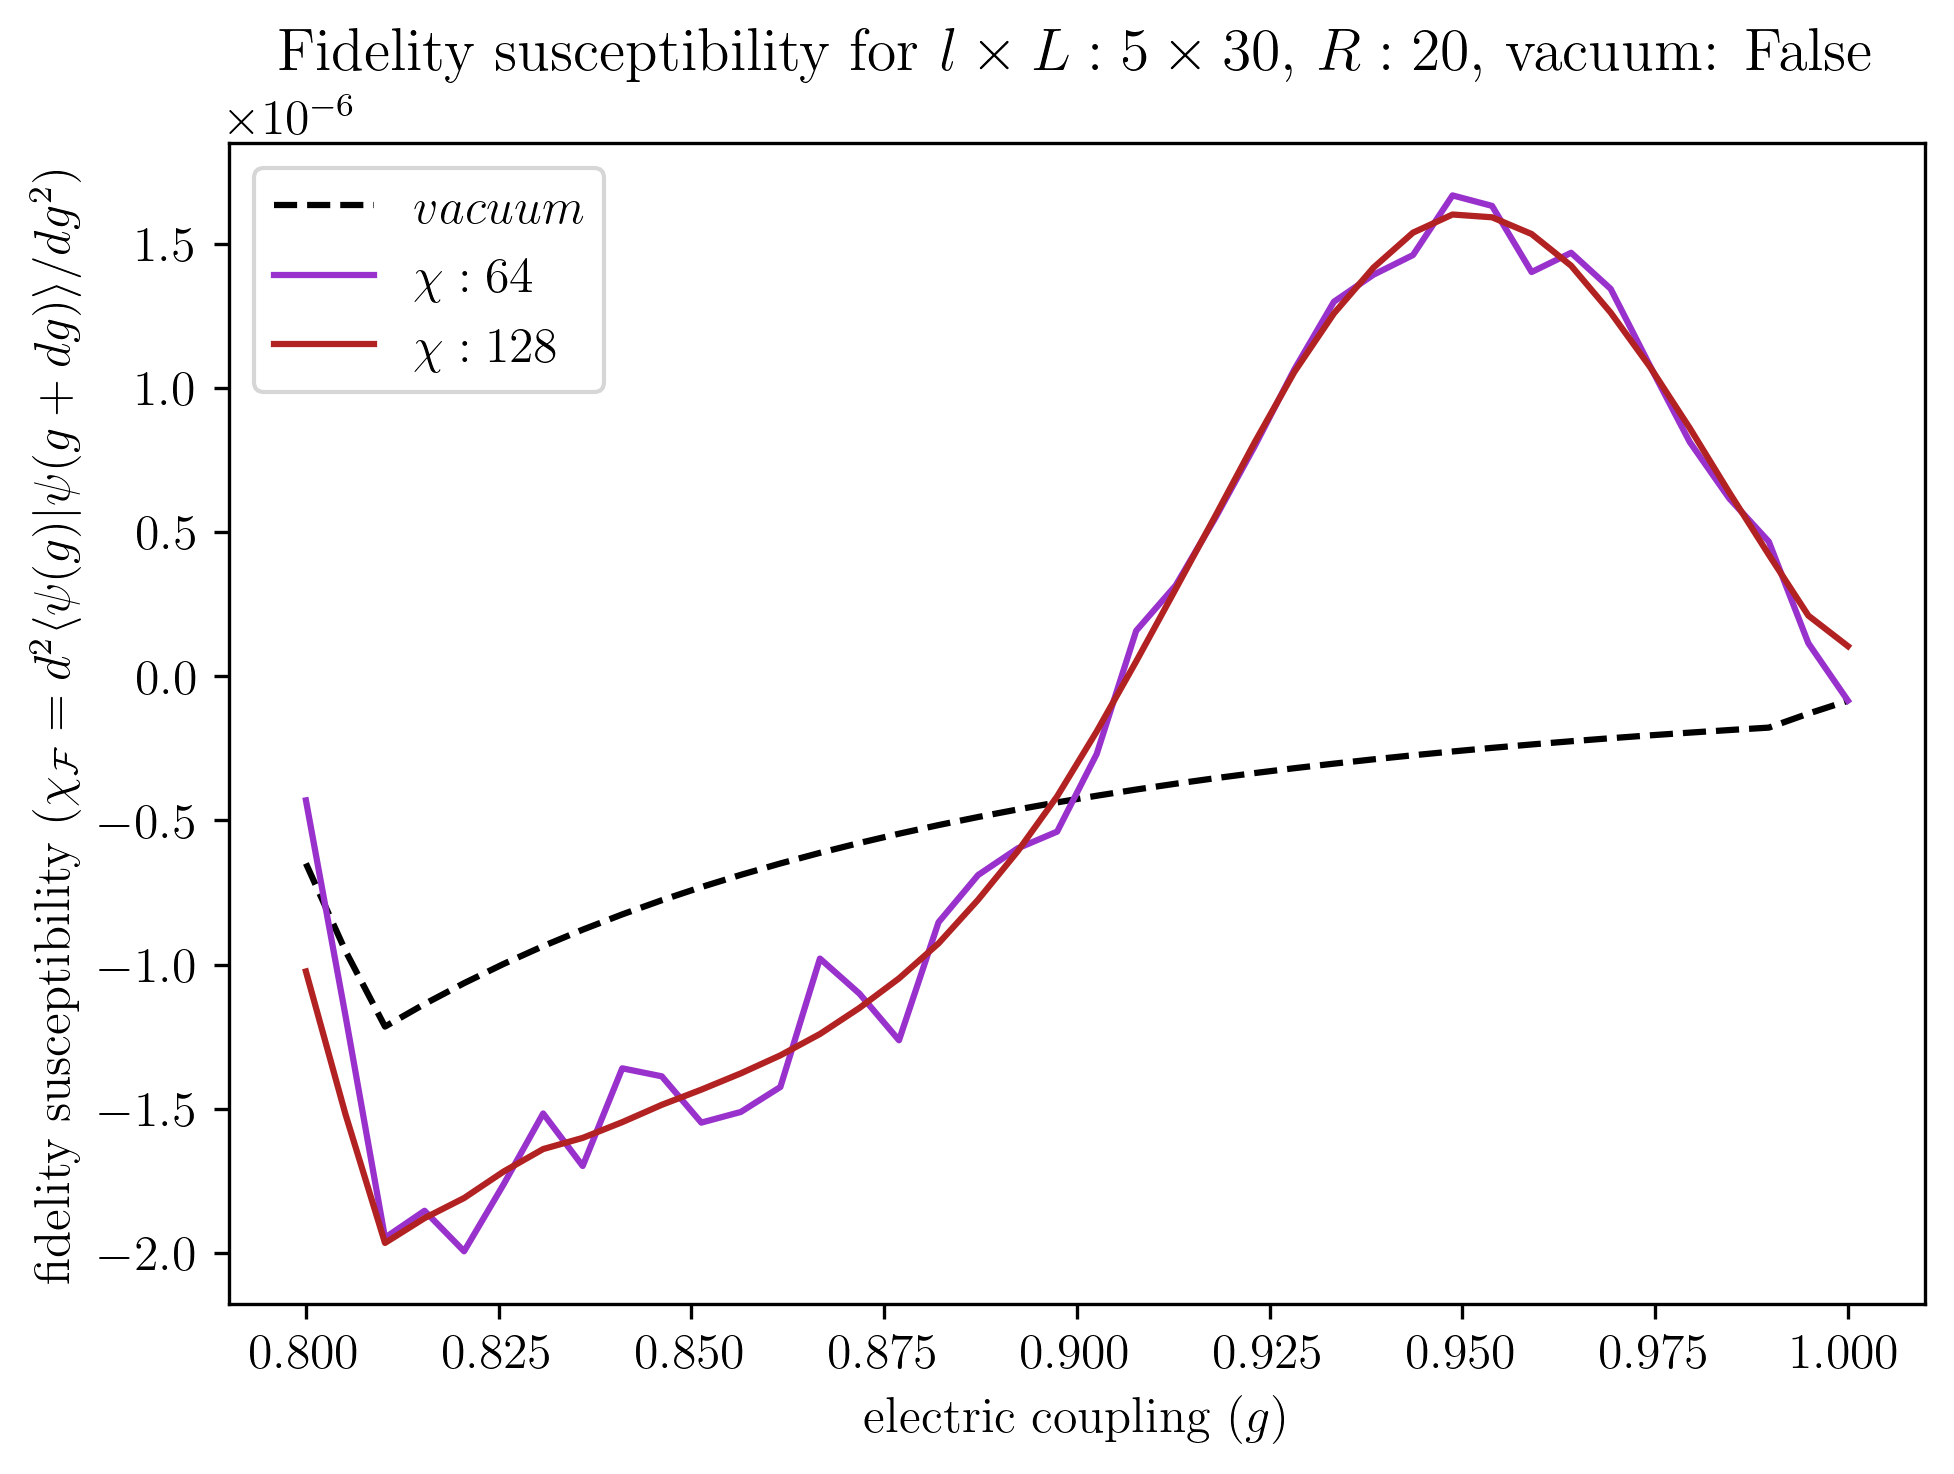

In [32]:
colors = ["darkorchid", "firebrick"]
for vacuum in [True, False]:
    i = 0
    gs = np.linspace(h_i, h_f, npoints-1)
    fid_vac = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{0}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.npy") 
    plt.plot(gs, np.abs(fid_vac), color='k', linestyle='--', label=f"$vacuum$")

    for chi in chis:
        
        plt.title(f"Fidelity susceptibility for $l \\times L: {l} \\times {L}$, $R:{Rs[-1]}$, vacuum: {vacuum}")
        # plt.title(f"$\\chi_{{\\mathcal{{F}}}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2$ for $l \\times L: {l} \\times {L}$, $D:{chi}$, $log: {log}$")
        plt.xlabel("electric coupling $(g)$")
        plt.ylabel("fidelity susceptibility $(\\chi_{\\mathcal{F}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2)$")
        
        fidelities = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{Rs[-1]}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
        if vacuum:
            fidelities = fidelities - fid_vac
        plt.plot(gs, np.abs(fidelities), color=colors[i], label=f"$\\chi: {chi}$")
        i += 1
    plt.yscale('log')
    plt.savefig(f"{path_figures}/fluxtube/fidelity_susceptibility_log_scale_True_rdm_{rdm}_vacuum_{vacuum}_{model}_{l}x{L}_bc_{bc}_R_{Rs[-1]}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis}.png")
    plt.legend()
    plt.show()
    plt.close()

for vacuum in [True, False]:
    i = 0
    gs = np.linspace(h_i, h_f, npoints-1)
    fid_vac = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{0}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.npy") 
    plt.plot(gs, fid_vac, color='k', linestyle='--', label=f"$vacuum$")

    for chi in chis:
        
        plt.title(f"Fidelity susceptibility for $l \\times L: {l} \\times {L}$, $R:{Rs[-1]}$, vacuum: {vacuum}")
        # plt.title(f"$\\chi_{{\\mathcal{{F}}}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2$ for $l \\times L: {l} \\times {L}$, $D:{chi}$, $log: {log}$")
        plt.xlabel("electric coupling $(g)$")
        plt.ylabel("fidelity susceptibility $(\\chi_{\\mathcal{F}} = d^2 \\langle \\psi (g) | \\psi(g+dg) \\rangle / dg^2)$")
        
        fidelities = np.load(f"{parent_path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{Rs[-1]}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
        if vacuum:
            fidelities = fidelities - fid_vac
        plt.plot(gs, fidelities, color=colors[i], label=f"$\\chi: {chi}$")
        i += 1
    plt.legend()
    plt.savefig(f"{path_figures}/fluxtube/fidelity_susceptibility_log_scale_False_rdm_{rdm}_vacuum_{vacuum}_{model}_{l}x{L}_bc_{bc}_R_{Rs[-1]}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis}.png")
    plt.show()
    plt.close()